In [1]:
import numpy as np
import torch
import torch.nn as nn

D:\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


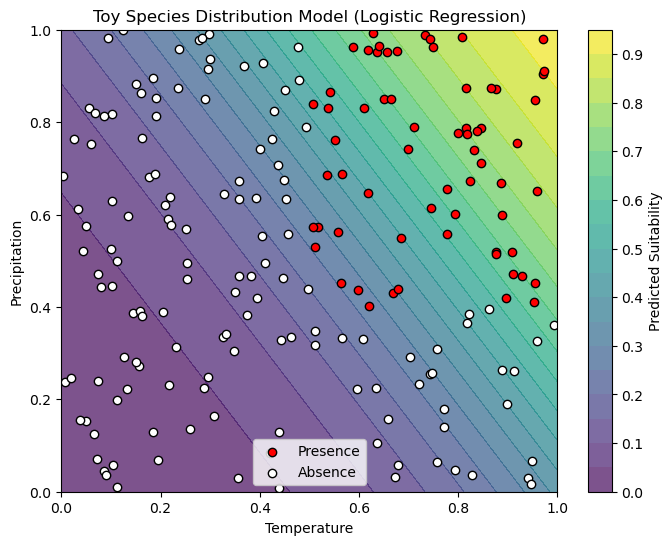

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# ---------------------------------------------------
# 1. Generate Simulated Presence/Absence Data
# ---------------------------------------------------
# Suppose we have 200 total samples, each with two environmental variables, e.g., temperature & precipitation.
num_samples = 200

# For demonstration, we'll simulate some random environmental variables in the range [0, 1].
temperature = np.random.rand(num_samples)
precipitation = np.random.rand(num_samples)

# Create a toy 'presence' vector, where presence depends on a made-up threshold relationship
# with temperature and precipitation. In reality, you'd have actual field data for presence.
presence = (
    (temperature > 0.5) & (precipitation > 0.4)
).astype(int)  # 1 -> presence, 0 -> absence

# Combine into a DataFrame for convenience.
df = pd.DataFrame({
    'temperature': temperature,
    'precipitation': precipitation,
    'presence': presence
})

# ---------------------------------------------------
# 2. Train a Logistic Regression Model
# ---------------------------------------------------
X = df[['temperature', 'precipitation']]
y = df['presence']

model = LogisticRegression()
model.fit(X, y)

# ---------------------------------------------------
# 3. Predict Suitability Across a Spatial Grid
# ---------------------------------------------------
# Let's simulate a grid of (temperature, precipitation) values.
grid_size = 100
temp_range = np.linspace(0, 1, grid_size)
prec_range = np.linspace(0, 1, grid_size)

# Create a meshgrid of temperature and precipitation.
temp_grid, prec_grid = np.meshgrid(temp_range, prec_range)

# Flatten the grid to pass it into the model.
X_grid = np.column_stack([temp_grid.ravel(), prec_grid.ravel()])

# Predict probability of presence (i.e., habitat suitability).
suitability = model.predict_proba(X_grid)[:, 1]  # Probability of presence is the second column

# Reshape the result back into grid form for plotting.
suitability_map = suitability.reshape(grid_size, grid_size)

# ---------------------------------------------------
# 4. Visualization
# ---------------------------------------------------
plt.figure(figsize=(8, 6))
# Show the suitability map. Higher = more suitable.
plt.contourf(temp_grid, prec_grid, suitability_map,
             levels=20, cmap='viridis', alpha=0.7)
plt.colorbar(label='Predicted Suitability')

# Overlay the presence (red) and absence (white) points.
presence_points = df[df['presence'] == 1]
absence_points = df[df['presence'] == 0]

plt.scatter(presence_points['temperature'],
            presence_points['precipitation'],
            color='red', edgecolor='k', label='Presence')
plt.scatter(absence_points['temperature'],
            absence_points['precipitation'],
            color='white', edgecolor='k', label='Absence')

plt.xlabel('Temperature')
plt.ylabel('Precipitation')
plt.title('Toy Species Distribution Model (Logistic Regression)')
plt.legend()
plt.show()

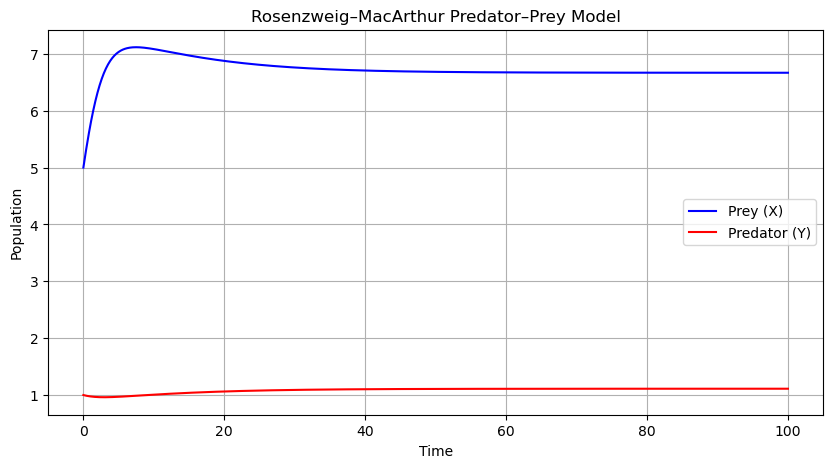

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def rosenzweig_macarthur(state, t, params):
    """
    Returns the time derivatives (dX/dt, dY/dt) for the Rosenzweig–MacArthur model.

    :param state: list or array of [X, Y] values at time t
    :param t: time (not used directly in the equations but required by odeint)
    :param params: dictionary of model parameters
    :return: list [dXdt, dYdt]
    """
    X, Y = state       # Unpack the current states: X for prey, Y for predator
    r = params['r']    # Prey intrinsic growth rate
    K = params['K']    # Prey carrying capacity
    a = params['a']    # Attack rate coefficient
    b = params['b']    # Handling time coefficient
    e = params['e']    # Conversion efficiency of prey into predator
    m = params['m']    # Predator mortality rate

    # PREY population change: logistic growth minus predation
    # predation term includes a Holling Type II functional response: aX / (1 + bX)
    predation_rate = (a * X) / (1 + b * X)  # per capita predation on X
    dXdt = r * X * (1 - X / K) - predation_rate * Y

    # PREDATOR population change: gained from consumed prey, lost by natural mortality
    dYdt = e * predation_rate * Y - m * Y

    return [dXdt, dYdt]

# -----------------------------------------------------
# Main Simulation
# -----------------------------------------------------
if __name__ == '__main__':
    # Define model parameters
    params = {
        'r': 1.0,   # Prey growth rate
        'K': 10.0,  # Prey carrying capacity
        'a': 0.5,   # Attack rate coefficient
        'b': 0.1,   # Handling time coefficient
        'e': 0.1,   # Conversion efficiency
        'm': 0.2    # Predator mortality rate
    }

    # Initial populations for prey (X0) and predator (Y0)
    X0 = 5.0
    Y0 = 1.0

    # Time points at which to compute the solution
    t = np.linspace(0, 100, 1000)

    # Integrate (solve) the ODE system
    # state0 is the initial condition [X0, Y0]
    state0 = [X0, Y0]
    sol = odeint(rosenzweig_macarthur, state0, t, args=(params,))

    # Extract the time-series for prey (X) and predator (Y)
    X_sol = sol[:, 0]
    Y_sol = sol[:, 1]

    # -----------------------------------------------------
    # Visualization
    # -----------------------------------------------------
    plt.figure(figsize=(10, 5))

    # Plot Prey and Predator over time
    plt.plot(t, X_sol, label='Prey (X)', color='blue')
    plt.plot(t, Y_sol, label='Predator (Y)', color='red')

    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.title("Rosenzweig–MacArthur Predator–Prey Model")
    plt.legend()
    plt.grid(True)
    plt.show()

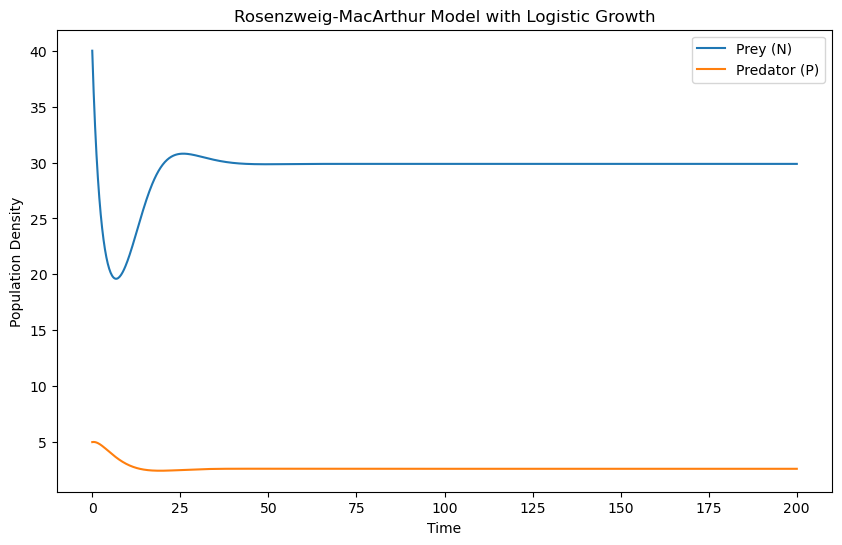

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# 模型参数
r = 0.5  # 猎物增长率
K = 50   # 猎物承载力
a = 0.1  # 捕食效率
h = 0.1  # 捕食处理时间
e = 0.1  # 捕食者能量转化效率
m = 0.2  # 捕食者死亡率
K_P = 20 # 捕食者承载力

# 模型方程
def rosenzweig_macarthur(y, t, r, K, a, h, e, m, K_P):
    N, P = y  # 猎物和捕食者的种群密度
    dNdt = r * N * (1 - N / K) - (a * N * P) / (1 + a * h * N)
    dPdt = e * (a * N * P) / (1 + a * h * N) * (1 - P / K_P) - m * P
    return [dNdt, dPdt]

# 初始值
N0 = 40  # 初始猎物密度
P0 = 5   # 初始捕食者密度
y0 = [N0, P0]

# 时间范围
t = np.linspace(0, 200, 1000)

# 求解方程
solution = odeint(rosenzweig_macarthur, y0, t, args=(r, K, a, h, e, m, K_P))
N, P = solution.T

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(t, N, label="Prey (N)")
plt.plot(t, P, label="Predator (P)")
plt.xlabel("Time")
plt.ylabel("Population Density")
plt.legend()
plt.title("Rosenzweig-MacArthur Model with Logistic Growth")
plt.show()


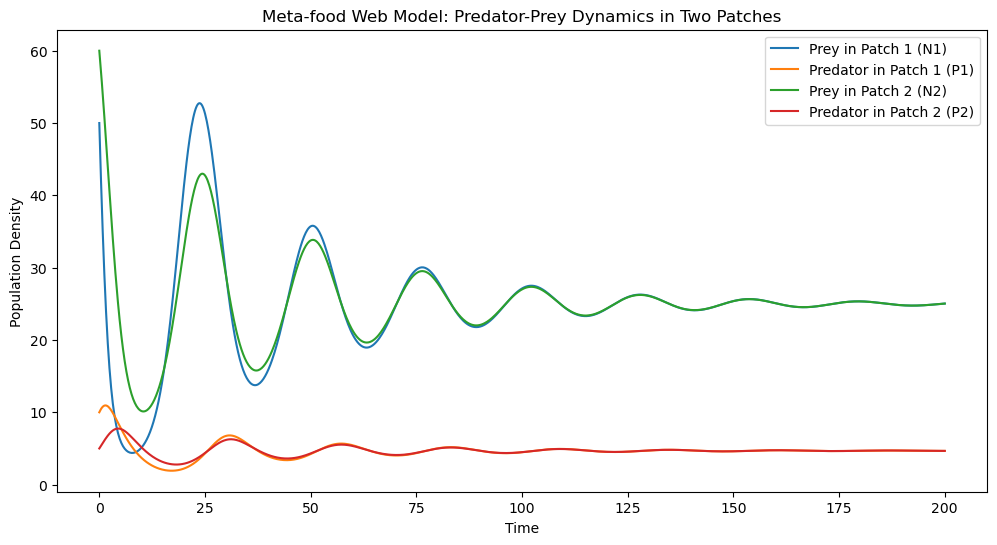

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# 模型参数
r = 0.5  # 猎物增长率
K = 100  # 猎物承载力
a = 0.1  # 捕食效率
h = 0.1  # 捕食处理时间
e = 0.1  # 捕食者转化效率
m = 0.2  # 捕食者死亡率
D = 0.01 # 迁移率

# 模型方程
def meta_food_web(y, t, r, K, a, h, e, m, D):
    N1, P1, N2, P2 = y  # 两个斑块的猎物和捕食者
    dN1dt = r * N1 * (1 - N1 / K) - (a * N1 * P1) / (1 + a * h * N1) + D * (N2 - N1)
    dP1dt = e * (a * N1 * P1) / (1 + a * h * N1) - m * P1 + D * (P2 - P1)
    dN2dt = r * N2 * (1 - N2 / K) - (a * N2 * P2) / (1 + a * h * N2) + D * (N1 - N2)
    dP2dt = e * (a * N2 * P2) / (1 + a * h * N2) - m * P2 + D * (P1 - P2)
    return [dN1dt, dP1dt, dN2dt, dP2dt]

# 初始条件
y0 = [50, 10, 60, 5]  # [N1, P1, N2, P2]
t = np.linspace(0, 200, 1000)  # 时间范围

# 求解方程
solution = odeint(meta_food_web, y0, t, args=(r, K, a, h, e, m, D))
N1, P1, N2, P2 = solution.T

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(t, N1, label="Prey in Patch 1 (N1)")
plt.plot(t, P1, label="Predator in Patch 1 (P1)")
plt.plot(t, N2, label="Prey in Patch 2 (N2)")
plt.plot(t, P2, label="Predator in Patch 2 (P2)")
plt.xlabel("Time")
plt.ylabel("Population Density")
plt.legend()
plt.title("Meta-food Web Model: Predator-Prey Dynamics in Two Patches")
plt.show()


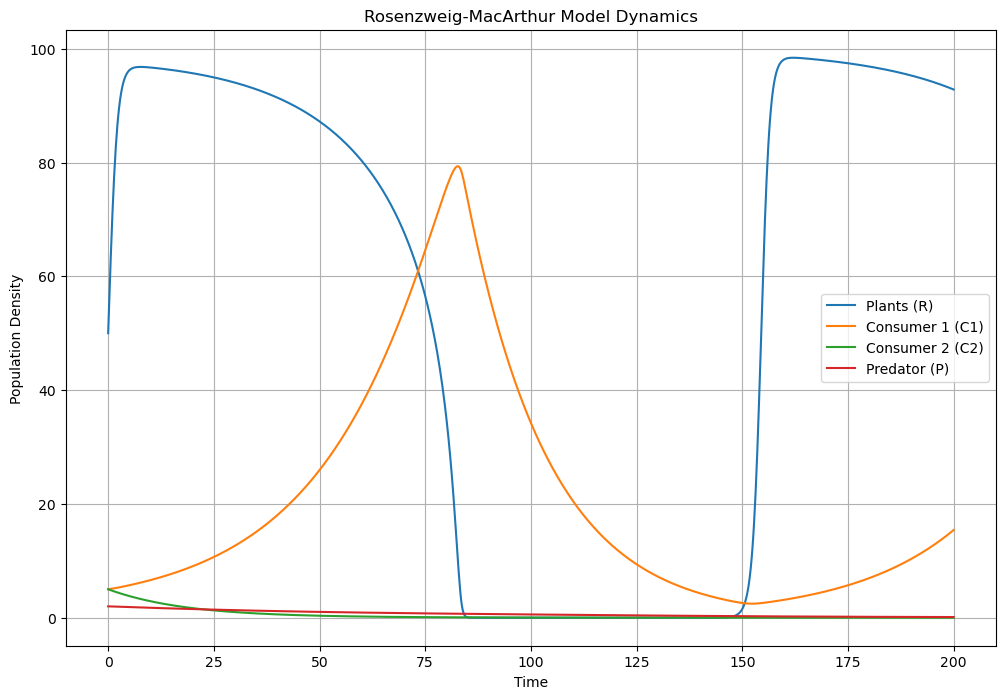

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# 定义 Rosenzweig-MacArthur 模型
def rosenzweig_macarthur(y, t, params):
    R, C1, C2, P = y  # 解变量
    r, K, a1, h1, e1, m1, b1, g1, a2, h2, e2, m2, b2, g2, e3, m3 = params

    dRdt = r * R * (1 - R / K) - (a1 * R / (h1 + R)) * C1 - (a2 * R / (h2 + R)) * C2
    dC1dt = e1 * (a1 * R / (h1 + R)) * C1 - m1 * C1 - (b1 * C1 / (g1 + C1)) * P
    dC2dt = e2 * (a2 * R / (h2 + R)) * C2 - m2 * C2 - (b2 * C2 / (g2 + C2)) * P
    dPdt = e3 * ((b1 * C1 / (g1 + C1)) + (b2 * C2 / (g2 + C2))) * P - m3 * P

    return [dRdt, dC1dt, dC2dt, dPdt]

# 参数设置
params = {
    "r": 1.0,     # 植物的固有增长率
    "K": 100.0,   # 植物的环境承载力
    "a1": 0.5,    # 初级消费者1对植物的捕食率
    "h1": 10.0,   # 植物密度的半饱和常数
    "e1": 0.2,    # 植物转化为初级消费者1的效率
    "m1": 0.05,   # 初级消费者1的死亡率
    "b1": 0.1,    # 食肉动物捕食初级消费者1的捕食率
    "g1": 10.0,   # 初级消费者1密度的半饱和常数
    "a2": 0.1,    # 初级消费者2对植物的捕食率
    "h2": 10.0,   # 植物密度的半饱和常数
    "e2": 0.1,    # 植物转化为初级消费者2的效率
    "m2": 0.05,   # 初级消费者2的死亡率
    "b2": 0.1,    # 食肉动物捕食初级消费者2的捕食率
    "g2": 10.0,   # 初级消费者2密度的半饱和常数
    "e3": 0.1,    # 初级消费者转化为食肉动物的效率
    "m3": 0.02    # 食肉动物的死亡率
}

# 初始条件
R0 = 50.0    # 初始植物密度
C1_0 = 5.0   # 初级消费者1的初始密度
C2_0 = 5.0   # 初级消费者2的初始密度
P0 = 2.0     # 食肉动物的初始密度

# 时间范围
t = np.linspace(0, 200, 1000)  # 模拟 0 到 200 时间单位，共 1000 个点

# 初始状态
y0 = [R0, C1_0, C2_0, P0]

# 参数值列表
param_values = list(params.values())

# 求解微分方程
solution = odeint(rosenzweig_macarthur, y0, t, args=(param_values,))

# 提取解
R, C1, C2, P = solution.T

# 绘图
plt.figure(figsize=(12, 8))
plt.plot(t, R, label="Plants (R)")
plt.plot(t, C1, label="Consumer 1 (C1)")
plt.plot(t, C2, label="Consumer 2 (C2)")
plt.plot(t, P, label="Predator (P)")
plt.xlabel("Time")
plt.ylabel("Population Density")
plt.title("Rosenzweig-MacArthur Model Dynamics")
plt.legend()
plt.grid()
plt.show()


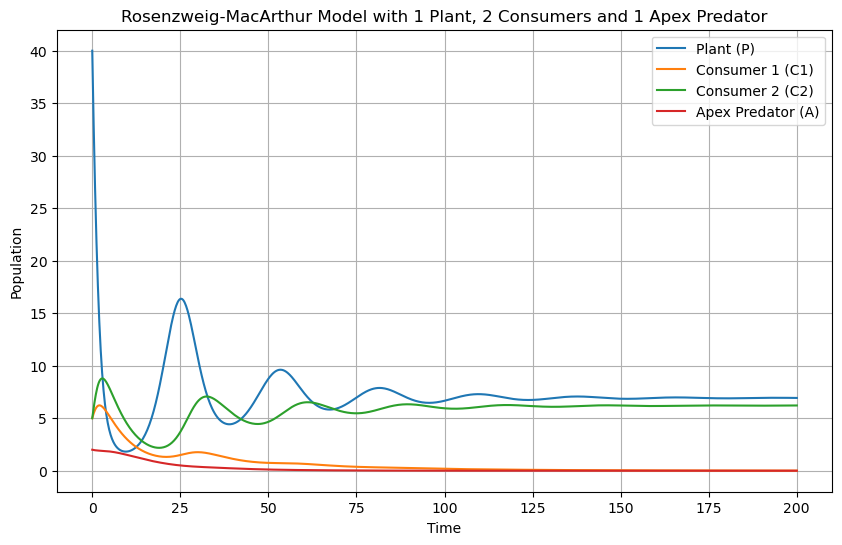

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def rosenzweig_macarthur(t, y, params):
    """
    y = [P, C1, C2, A]
    P: Plant population
    C1: Consumer 1 population
    C2: Consumer 2 population
    A: Apex predator population

    params = {
        'r':  植物的内禀增长率,
        'K':  植物的环境容纳量 (logistic growth),
        'a1': 消费者1对植物的最大摄食率,
        'h1': 消费者1对植物的处理时间,
        'e1': 消费者1摄食的同化效率,
        'd1': 消费者1的死亡率 (或耗散项),
        'a2': 消费者2对植物的最大摄食率,
        'h2': 消费者2对植物的处理时间,
        'e2': 消费者2摄食的同化效率,
        'd2': 消费者2的死亡率,
        'ap1': 食肉动物对消费者1的最大摄食率,
        'hp1': 食肉动物对消费者1的处理时间,
        'ap2': 食肉动物对消费者2的最大摄食率,
        'hp2': 食肉动物对消费者2的处理时间,
        'ep':  食肉动物摄食的同化效率,
        'dp':  食肉动物死亡率
    }
    """
    P, C1, C2, A = y
    r   = params['r']
    K   = params['K']

    # Consumer1对植物的饱和摄食
    a1  = params['a1']
    h1  = params['h1']
    e1  = params['e1']
    d1  = params['d1']

    # Consumer2对植物的饱和摄食
    a2  = params['a2']
    h2  = params['h2']
    e2  = params['e2']
    d2  = params['d2']

    # Apex predator对Consumer1和Consumer2的饱和摄食
    ap1 = params['ap1']
    hp1 = params['hp1']
    ap2 = params['ap2']
    hp2 = params['hp2']
    ep  = params['ep']
    dp  = params['dp']

    # Rosenzweig-MacArthur函数形式通常采用 Type II 函数 (Holling's type II)
    # 摄食速率示例: (a * Prey * Predator) / (1 + a*h*Prey)

    # 对植物的对数增长
    dPdt = r * P * (1 - P / K)

    # 计算 C1 对植物的摄食以及食肉动物对 C1 的捕食
    fC1_on_P  = (a1 * P * C1) / (1 + a1 * h1 * P)  # C1摄食植物
    fA_on_C1  = (ap1 * C1 * A) / (1 + ap1 * hp1 * C1)  # A摄食C1

    # 计算 C2 对植物的摄食以及食肉动物对 C2 的捕食
    fC2_on_P  = (a2 * P * C2) / (1 + a2 * h2 * P)  # C2摄食植物
    fA_on_C2  = (ap2 * C2 * A) / (1 + ap2 * hp2 * C2)  # A摄食C2

    # 植物种群变化 (被C1和C2摄食后损失)
    dPdt -= fC1_on_P
    dPdt -= fC2_on_P

    # C1种群变化 (从植物获取能量 - 被食肉动物捕食 - 自然死亡)
    dC1dt = e1 * fC1_on_P - fA_on_C1 - d1 * C1

    # C2种群变化 (从植物获取能量 - 被食肉动物捕食 - 自然死亡)
    dC2dt = e2 * fC2_on_P - fA_on_C2 - d2 * C2

    # 食肉动物种群变化 (分别从C1和C2获取能量 - 自然死亡)
    dAdt = ep * (fA_on_C1 + fA_on_C2) - dp * A

    return [dPdt, dC1dt, dC2dt, dAdt]

# 示例参数设置
params = {
    'r'   : 0.5,   # 植物内禀增长率
    'K'   : 50.0,  # 植物环境容纳量
    'a1'  : 0.05,  # C1最大摄食率
    'h1'  : 0.01,  # C1处理时间
    'e1'  : 0.2,   # C1同化效率
    'd1'  : 0.1,   # C1死亡率
    'a2'  : 0.07,  # C2最大摄食率
    'h2'  : 0.02,  # C2处理时间
    'e2'  : 0.25,  # C2同化效率
    'd2'  : 0.12,  # C2死亡率
    'ap1' : 0.02,  # 食肉动物对C1最大摄食率
    'hp1' : 0.01,  # 食肉动物对C1处理时间
    'ap2' : 0.02,  # 食肉动物对C2最大摄食率
    'hp2' : 0.01,  # 食肉动物对C2处理时间
    'ep'  : 0.3,   # 食肉动物同化效率
    'dp'  : 0.1    # 食肉动物死亡率
}

# 初始种群数量
y0 = [40.0, 5.0, 5.0, 2.0]  # P, C1, C2, A

# 时间范围
t_span = (0, 200)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# 求解方程
sol = solve_ivp(lambda t, y: rosenzweig_macarthur(t, y, params),
                t_span, y0, t_eval=t_eval, rtol=1e-8, atol=1e-8)

# 提取结果
P_sol, C1_sol, C2_sol, A_sol = sol.y

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(sol.t, P_sol, label='Plant (P)')
plt.plot(sol.t, C1_sol, label='Consumer 1 (C1)')
plt.plot(sol.t, C2_sol, label='Consumer 2 (C2)')
plt.plot(sol.t, A_sol, label='Apex Predator (A)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Rosenzweig-MacArthur Model with 1 Plant, 2 Consumers and 1 Apex Predator')
plt.legend()
plt.grid(True)
plt.show()

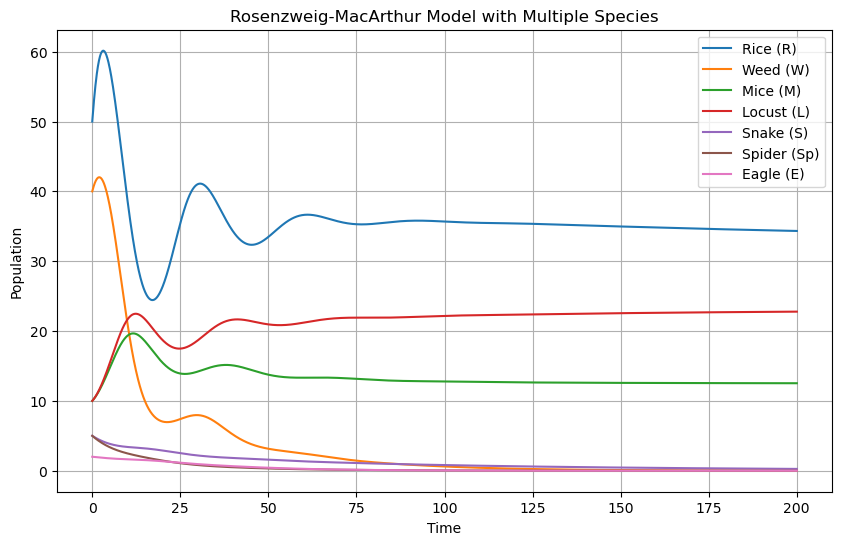

In [5]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def rosenzweig_macarthur_model(y, t, params):
    """
    Defines the ODEs for a 7-species Rosenzweig-MacArthur system:
      R(t)  : Rice
      W(t)  : Weed
      M(t)  : Mice
      L(t)  : Locust
      S(t)  : Snake
      Sp(t) : Spider
      E(t)  : Eagle
    """
    # Unpack state variables
    R, W, M, L, S, Sp, E = y

    # Unpack parameters (logistic growth, consumption, assimilation, death rates, etc.)
    (rR, KR, rW, KW,
     aRM, bRM, eMR, aRW, bRW, eMW,  # Mice consumption of Rice/Weed
     aLM, bLM, eML, aLW, bLW, eMW2, # Locust consumption of Rice/Weed
     aSM, bSM, eSM, aSL, bSL, eSL,  # Snake consumption of Mice/Locust
     aSpL, bSpL, eSpL,             # Spider consumption of Locust
     aES, bES, eES, aEM, bEM, eEM, aESp, bESp, eESp,
     dM, dL, dS, dSp, dE) = params

    # ----------------------------
    # Producers (Rice: R, Weed: W)
    # Logistic growth - sum of being eaten by Mice (M) and Locust (L)
    # Functional response: (aXY * X * Y) / (1 + bXY * X)
    # ----------------------------
    # dR/dt
    consumption_by_mice_R = (aRM * R * M) / (1 + bRM * R)
    consumption_by_locust_R = (aLM * R * L) / (1 + bLM * R)
    dRdt = rR * R * (1 - R / KR) - consumption_by_mice_R - consumption_by_locust_R

    # dW/dt
    consumption_by_mice_W = (aRW * W * M) / (1 + bRW * W)
    consumption_by_locust_W = (aLW * W * L) / (1 + bLW * W)
    dWdt = rW * W * (1 - W / KW) - consumption_by_mice_W - consumption_by_locust_W

    # ----------------------------
    # Primary consumers (Mice: M, Locust: L)
    # Gain from eating producers - loss from being eaten by predators
    # ----------------------------
    # dM/dt
    eaten_from_rice = eMR * consumption_by_mice_R
    eaten_from_weed = eMW * consumption_by_mice_W
    # Mice eaten by Snake and Eagle
    consumption_by_snake_on_mice = (aSM * M * S) / (1 + bSM * M)
    consumption_by_eagle_on_mice = (aEM * M * E) / (1 + bEM * M)
    dMdt = eaten_from_rice + eaten_from_weed \
           - consumption_by_snake_on_mice \
           - consumption_by_eagle_on_mice \
           - dM * M

    # dL/dt
    eaten_from_rice_L = eML * consumption_by_locust_R
    eaten_from_weed_L = eMW2 * consumption_by_locust_W
    # Locust eaten by Snake and Spider
    consumption_by_snake_on_locust = (aSL * L * S) / (1 + bSL * L)
    consumption_by_spider_on_locust = (aSpL * L * Sp) / (1 + bSpL * L)
    dLdt = eaten_from_rice_L + eaten_from_weed_L \
           - consumption_by_snake_on_locust \
           - consumption_by_spider_on_locust \
           - dL * L

    # ----------------------------
    # Secondary predators (Snake: S, Spider: Sp)
    # Gain from eating Mice/Locust - loss from being eaten by Eagle (Snake, Spider)
    # ----------------------------
    # dS/dt
    gain_snake_mice = eSM * consumption_by_snake_on_mice
    gain_snake_locust = eSL * consumption_by_snake_on_locust
    # Snake eaten by Eagle
    consumption_by_eagle_on_snake = (aES * S * E) / (1 + bES * S)
    dSdt = gain_snake_mice + gain_snake_locust \
           - consumption_by_eagle_on_snake \
           - dS * S

    # dSp/dt
    gain_spider_locust = eSpL * consumption_by_spider_on_locust
    # Spider eaten by Eagle
    consumption_by_eagle_on_spider = (aESp * Sp * E) / (1 + bESp * Sp)
    dSpdt = gain_spider_locust \
            - consumption_by_eagle_on_spider \
            - dSp * Sp

    # ----------------------------
    # Top predator (Eagle: E)
    # Gains from eating Snake, Mice, Spider - standard mortality
    # ----------------------------
    consumption_of_snake_by_eagle = (aES * S * E) / (1 + bES * S)
    consumption_of_mice_by_eagle = (aEM * M * E) / (1 + bEM * M)
    consumption_of_spider_by_eagle = (aESp * Sp * E) / (1 + bESp * Sp)
    gain_eagle_snake = eES * consumption_of_snake_by_eagle
    gain_eagle_mice = eEM * consumption_of_mice_by_eagle
    gain_eagle_spider = eESp * consumption_of_spider_by_eagle
    dEdt = gain_eagle_snake + gain_eagle_mice + gain_eagle_spider - dE * E

    return [dRdt, dWdt, dMdt, dLdt, dSdt, dSpdt, dEdt]


# Example parameter set (illustrative only)
params_example = (
    0.8, 100.0,  # rR, KR (Rice growth rate, carrying capacity)
    0.6, 80.0,   # rW, KW (Weed growth rate, carrying capacity)

    0.02, 0.01, 0.2,  # aRM, bRM, eMR (Mice consuming Rice)
    0.015, 0.01, 0.2, # aRW, bRW, eMW (Mice consuming Weed)

    0.02, 0.01, 0.2,  # aLM, bLM, eML (Locust consuming Rice)
    0.02, 0.01, 0.2,  # aLW, bLW, eMW2 (Locust consuming Weed)

    0.01, 0.01, 0.3,  # aSM, bSM, eSM (Snake consuming Mice)
    0.01, 0.01, 0.3,  # aSL, bSL, eSL (Snake consuming Locust)

    0.01, 0.01, 0.35, # aSpL, bSpL, eSpL (Spider consuming Locust)

    0.01, 0.01, 0.4,  # aES, bES, eES (Eagle consumes Snake)
    0.01, 0.01, 0.4,  # aEM, bEM, eEM (Eagle consumes Mice)
    0.01, 0.01, 0.4,  # aESp, bESp, eESp (Eagle consumes Spider)

    0.1, 0.1, 0.1, 0.1, 0.1  # dM, dL, dS, dSp, dE (natural death rates)
)

# Initial populations: R, W, M, L, S, Sp, E
y0 = [50, 40, 10, 10, 5, 5, 2]

# Time points
t = np.linspace(0, 200, 2001)

# Solve ODE
solution = odeint(rosenzweig_macarthur_model, y0, t, args=(params_example,))

# Extract each population from the solution
R_sol, W_sol, M_sol, L_sol, S_sol, Sp_sol, E_sol = solution.T

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, R_sol, label='Rice (R)')
plt.plot(t, W_sol, label='Weed (W)')
plt.plot(t, M_sol, label='Mice (M)')
plt.plot(t, L_sol, label='Locust (L)')
plt.plot(t, S_sol, label='Snake (S)')
plt.plot(t, Sp_sol, label='Spider (Sp)')
plt.plot(t, E_sol, label='Eagle (E)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Rosenzweig-MacArthur Model with Multiple Species')
plt.legend()
plt.grid(True)
plt.show()

D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32676 (\N{CJK UNIFIED IDEOGRAPH-7FA4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda\Lib\site

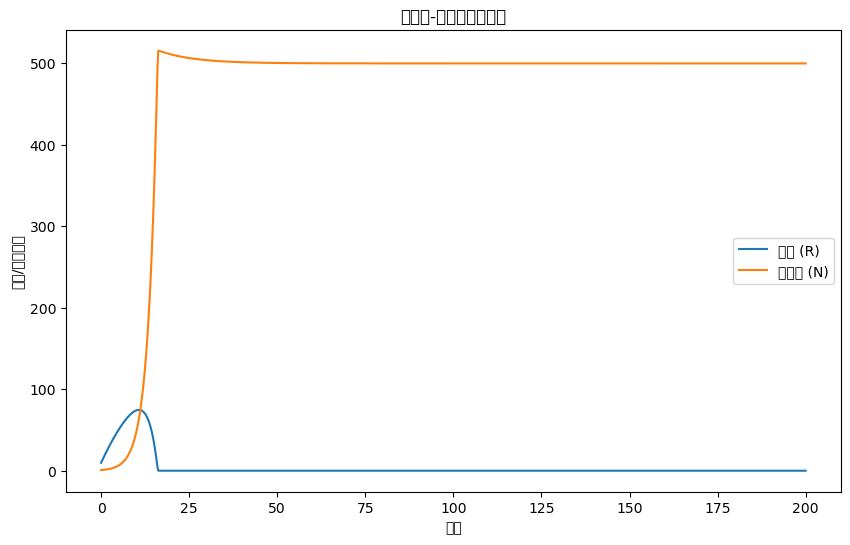

In [6]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# 定义模型
def microbial_model(y, t, params):
    R, N = y
    r, d, c, k, R_input, R_loss = params

    dR_dt = R_input - R_loss * R - c * R / (k + R) * N
    dN_dt = r * N * R / (k + R) - d * N

    return [dR_dt, dN_dt]

# 参数
params = [0.5, 0.1, 0.1, 1, 10, 0.05]  # r, d, c, k, R_input, R_loss
y0 = [10, 1]  # 初始资源浓度和微生物种群

# 时间范围
t = np.linspace(0, 200, 1000)

# 求解微分方程
result = odeint(microbial_model, y0, t, args=(params,))

# 绘图
R, N = result.T
plt.figure(figsize=(10, 6))
plt.plot(t, R, label="资源 (R)")
plt.plot(t, N, label="微生物 (N)")
plt.xlabel("时间")
plt.ylabel("浓度/种群数量")
plt.legend()
plt.title("单资源-微生物种群动态")
plt.show()


C:\Users\googl\AppData\Local\Temp\ipykernel_16640\230027655.py:85: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(microbial_competition, y0, t, args=(params,))


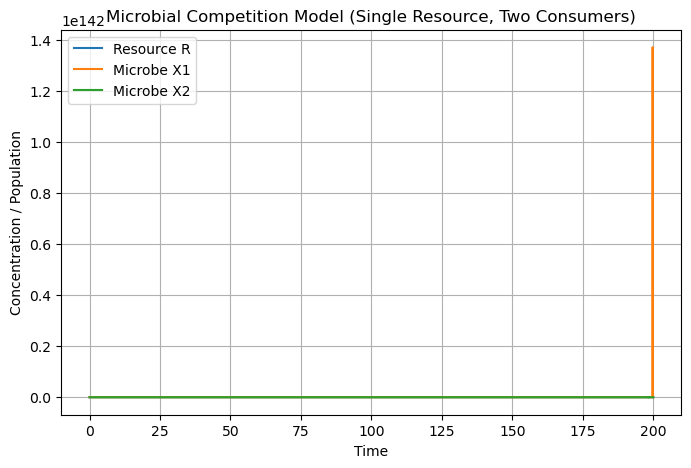

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def microbial_competition(y, t, params):
    """
    建立一个单一资源 R，与 n 个微生物种群 X_i 的竞争模型。

    y: [R, X1, X2, ..., Xn] 组成的向量
       R  : 资源浓度
       Xi : 第 i 个微生物种群的数量
    t: 时间
    params: 参数列表或元组，包含：
      - rR, KR: 资源自身的生长速率和环境承载量(若资源可以自我更新)
      - μi: 第 i 个微生物在资源可及时的最大生长速率
      - Ki: 第 i 个微生物对资源的半饱和常数（Monod动力学/米氏动力学）
      - αi: 第 i 个微生物对资源的摄取率系数
      - di: 第 i 个微生物自身的死亡率或流失率
    """
    # 从 y 中提取资源 R 以及微生物种群 X_i
    n = len(y) - 1  # y[0]是资源，后面 y[1:] 是 n 个微生物
    R = y[0]
    X = y[1:]

    # 从 params 中提取对应参数
    # 此处假设按顺序传入或使用字典都可以，这里示例用元组
    rR, KR = params[0], params[1]
    μ = params[2 : 2 + n]        # 一维列表 [μ1, μ2, ..., μn]
    K = params[2 + n : 2 + 2*n]  # 一维列表 [K1, K2, ..., Kn]
    α = params[2 + 2*n : 2 + 3*n]
    d = params[2 + 3*n : 2 + 4*n]

    # ---------------------------
    # 资源方程：若资源可自我再生(类似 logistic)，则：
    # dR/dt = rR * R * (1 - R/KR) - sum(αi * Xi * 摄取功能响应)
    # 摄取功能响应可采用 Monod: (R / (Ki + R))
    # ---------------------------
    consumption_terms = [α[i] * X[i] * R / (K[i] + R) for i in range(n)]
    dRdt = rR * R * (1 - R / KR) - sum(consumption_terms)

    # ---------------------------
    # 微生物方程：
    # dXi/dt = 生长 - 死亡
    # 生长可用(μi * R / (Ki + R)) * Xi
    # 死亡(包括基础代谢流失等)用 di * Xi
    # ---------------------------
    dXdt = []
    for i in range(n):
        growth_i = μ[i] * (R / (K[i] + R)) * X[i]
        death_i = d[i] * X[i]
        dXdt.append(growth_i - death_i)

    return [dRdt] + dXdt

# -------------------------------
# 示例：假设有两个微生物群落 X1、X2 争夺资源 R
# -------------------------------
# 参数示例（仅用于演示）
rR = 0.8   # 资源最大增长率
KR = 50.0  # 资源环境承载量

μ1, μ2 = 0.5, 0.4  # 两种微生物最大生长速率
K1, K2 = 5.0, 5.0  # 半饱和常数
α1, α2 = 0.1, 0.08 # 摄取率系数
d1, d2 = 0.05, 0.05# 死亡率

params = (
    rR,
    KR,
    μ1, μ2,
    K1, K2,
    α1, α2,
    d1, d2
)

# 初始条件：资源R0, 微生物 X10, X20
R0 = 10.0
X10, X20 = 1.0, 2.0
y0 = [R0, X10, X20]

# 时间区间
t = np.linspace(0, 200, 2001)

# 求解
solution = odeint(microbial_competition, y0, t, args=(params,))
R_sol = solution[:, 0]
X1_sol = solution[:, 1]
X2_sol = solution[:, 2]

# 结果可视化
plt.figure(figsize=(8, 5))
plt.plot(t, R_sol, label='Resource R')
plt.plot(t, X1_sol, label='Microbe X1')
plt.plot(t, X2_sol, label='Microbe X2')
plt.xlabel('Time')
plt.ylabel('Concentration / Population')
plt.title('Microbial Competition Model (Single Resource, Two Consumers)')
plt.legend()
plt.grid(True)
plt.show()

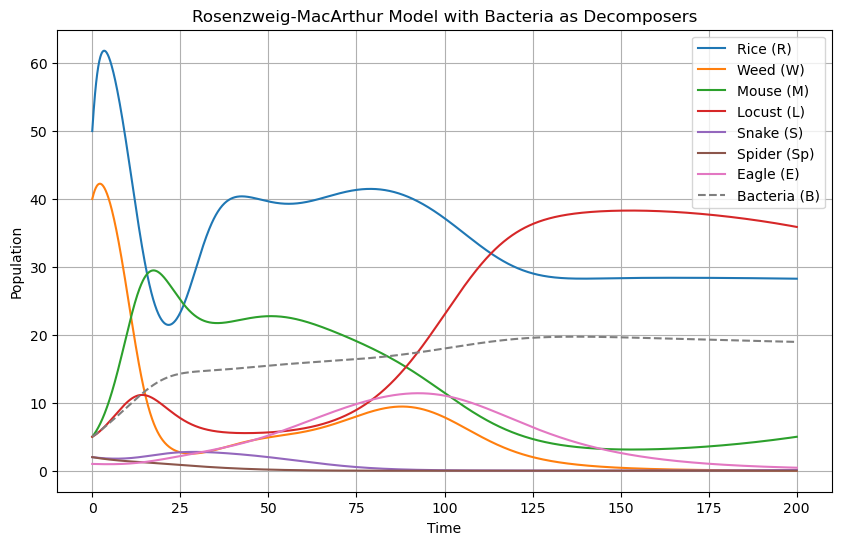

In [11]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def rosenzweig_macarthur_with_bacteria(y, t, params):
    """
    建立一个包含 8 个物种的 Rosenzweig-MacArthur 型模型:
      1)  R(t):  水稻 (生产者)
      2)  W(t):  稗草 (生产者)
      3)  M(t):  鼠 (初级捕食者)         - 吃水稻 R、稗草 W、细菌 B
      4)  L(t):  蝗虫 (初级捕食者)       - 吃水稻 R、稗草 W、细菌 B
      5)  S(t):  蛇 (次级捕食者)         - 吃鼠 M、蝗虫 L
      6)  Sp(t): 蜘蛛 (次级捕食者)       - 吃蝗虫 L
      7)  E(t):  鹰 (顶级捕食者)         - 吃蛇 S、蜘蛛 Sp、鼠 M
      8)  B(t):  细菌 (分解者)           - 利用各物种的死亡, 并被鼠 M、蝗虫 L 摄食

    其中:
    - 细菌 B(t) 的增长来自于 (各物种死亡率 × 对应种群数量) 的加权和(乘系数 alphaB)，
      并且被鼠和蝗虫摄食。
    - 其余捕食-被捕食关系均采用 Rosenzweig-MacArthur (Holling II) 型函数响应:
         (aXY * X * Y) / (1 + bXY * X)
      其中 X 表示被捕食者数量, Y 表示捕食者数量, aXY、bXY 为捕食率和处理时间系数等。
    """

    # 状态变量解包
    R, W, M, L, S, Sp, E, B = y

    # 从 params 中解包所有参数
    # 以下只是示意, 实际可能需要更多/更细的参数设置
    (
        # 生产者参数 (水稻R, 稗草W)
        rR, KR,   # 水稻 R 的增长率、环境容量
        rW, KW,   # 稗草 W 的增长率、环境容量

        # 鼠 M 对 (R, W, B) 的捕食系数与效率
        aRM, bRM, eMR,   # M 吃 R
        aWM, bWM, eMW,   # M 吃 W
        aBM, bBM, eMB,   # M 吃 B

        # 蝗虫 L 对 (R, W, B) 的捕食系数与效率
        aRL, bRL, eLR,   # L 吃 R
        aWL, bWL, eLW,   # L 吃 W
        aBL, bBL, eLB,   # L 吃 B

        # 蛇 S 对 (M, L) 的捕食系数与效率
        aSM, bSM, eSM,
        aSL, bSL, eSL,

        # 蜘蛛 Sp 对 (L) 的捕食系数与效率
        aSpL, bSpL, eSpL,

        # 鹰 E 对 (S, Sp, M) 的捕食系数与效率
        aES, bES, eES,   # E 吃 S
        aESp, bESp, eESp,# E 吃 Sp
        aEM, bEM, eEM,   # E 吃 M

        # 细菌 B 分解系数
        alphaB,

        # 各物种死亡率
        dR, dW, dM, dL, dS, dSp, dE, dB
    ) = params

    # ------------------------------------------------------
    # 1. 水稻 R(t) 和 稗草 W(t) (生产者, logistic 增长 - 消耗)
    # ------------------------------------------------------
    # 鼠对水稻 R 的消耗
    cons_R_by_M = (aRM * R * M) / (1.0 + bRM * R)
    # 蝗虫对水稻 R 的消耗
    cons_R_by_L = (aRL * R * L) / (1.0 + bRL * R)

    # 这里也可视情况添加 dR * R 表示资源衰亡(可选), 样例中演示
    dRdt = rR * R * (1 - R / KR) - cons_R_by_M - cons_R_by_L - dR * R

    # 稗草 W(t) - 同理
    cons_W_by_M = (aWM * W * M) / (1.0 + bWM * W)
    cons_W_by_L = (aWL * W * L) / (1.0 + bWL * W)
    dWdt = rW * W * (1 - W / KW) - cons_W_by_M - cons_W_by_L - dW * W

    # ------------------------------------------------------
    # 2. 鼠 M(t) 与 蝗虫 L(t) (初级捕食者)
    #    进食(生产者 + 细菌) -> 增长 - 被更高营养级捕食 - 自然死亡
    # ------------------------------------------------------
    # 鼠从水稻、稗草、细菌摄入
    gain_M_from_R = eMR * cons_R_by_M
    gain_M_from_W = eMW * cons_W_by_M
    cons_B_by_M = (aBM * B * M) / (1.0 + bBM * B)
    gain_M_from_B = eMB * cons_B_by_M

    # 鼠被蛇、鹰捕食
    cons_M_by_S = (aSM * M * S) / (1.0 + bSM * M)
    cons_M_by_E = (aEM * M * E) / (1.0 + bEM * M)

    dMdt = (gain_M_from_R + gain_M_from_W + gain_M_from_B) \
           - cons_M_by_S - cons_M_by_E \
           - dM * M

    # 蝗虫从水稻、稗草、细菌摄入
    gain_L_from_R = eLR * cons_R_by_L
    gain_L_from_W = eLW * cons_W_by_L
    cons_B_by_L = (aBL * B * L) / (1.0 + bBL * B)
    gain_L_from_B = eLB * cons_B_by_L

    # 蝗虫被蛇、蜘蛛捕食
    cons_L_by_S = (aSL * L * S) / (1.0 + bSL * L)
    cons_L_by_Sp = (aSpL * L * Sp) / (1.0 + bSpL * L)

    dLdt = (gain_L_from_R + gain_L_from_W + gain_L_from_B) \
           - cons_L_by_S - cons_L_by_Sp \
           - dL * L

    # ------------------------------------------------------
    # 3. 蛇 S(t), 蜘蛛 Sp(t) (次级捕食者)
    # ------------------------------------------------------
    # 蛇 S(t):
    gain_S_from_M = eSM * cons_M_by_S
    gain_S_from_L = eSL * cons_L_by_S
    # 蛇被鹰捕食
    cons_S_by_E = (aES * S * E) / (1.0 + bES * S)
    dSdt = (gain_S_from_M + gain_S_from_L) \
           - cons_S_by_E \
           - dS * S

    # 蜘蛛 Sp(t):
    gain_Sp_from_L = eSpL * cons_L_by_Sp
    # 蜘蛛被鹰捕食 (若不考虑可省略, 这里随示例给出)
    cons_Sp_by_E = (aESp * Sp * E) / (1.0 + bESp * Sp)
    dSpdt = gain_Sp_from_L - cons_Sp_by_E - dSp * Sp

    # ------------------------------------------------------
    # 4. 鹰 E(t) (顶级捕食者)
    # ------------------------------------------------------
    cons_S_by_E = (aES * S * E) / (1.0 + bES * S)   # 上面已定义, 这里重用
    cons_Sp_by_E = (aESp * Sp * E) / (1.0 + bESp * Sp)
    cons_M_by_E2 = (aEM * M * E) / (1.0 + bEM * M)  # 上面已定义, 这里重用

    gain_E_from_S = eES * cons_S_by_E
    gain_E_from_Sp = eESp * cons_Sp_by_E
    gain_E_from_M = eEM * cons_M_by_E2

    dEdt = gain_E_from_S + gain_E_from_Sp + gain_E_from_M - dE * E

    # ------------------------------------------------------
    # 5. 细菌 B(t) (分解者)
    #    - 来自各物种的死亡(乘以对应种群数量, 并汇总) * alphaB
    #    - 被鼠、蝗虫消费
    #    - 自然死亡 dB * B
    # ------------------------------------------------------
    # 注意：若要让生产者R、W的死亡也贡献给细菌，需加 dR*R, dW*W
    # 这里全部加上以示例
    total_death_flux = (dR * R + dW * W + dM * M + dL * L + dS * S + dSp * Sp + dE * E)

    # 细菌由生物死亡提供的营养转换(可理解为“分解”)
    bacteria_growth = alphaB * total_death_flux

    # 细菌被鼠、蝗虫摄食
    # cons_B_by_M2 = (aBM * B * M) / (1.0 + bBM * B)  # 上面已定义
    # cons_B_by_L2 = (aBL * B * L) / (1.0 + bBL * B)  # 上面已定义
    cons_B_by_M2=0
    cons_B_by_L2=0
    dBdt = bacteria_growth - cons_B_by_M2 - cons_B_by_L2 - dB * B

    return [dRdt, dWdt, dMdt, dLdt, dSdt, dSpdt, dEdt, dBdt]


# ---------------------------
# 示例参数 (仅用于演示, 请根据实际需要进行调整)
# ---------------------------
params_example = (
    # 水稻R: logistic
    0.8, 80.0,    # rR, KR
    # 稗草W: logistic
    0.6, 60.0,    # rW, KW

    # 鼠 M 消费(水稻 R, 稗草 W, 细菌 B)
    0.02, 0.01, 0.2,    # aRM, bRM, eMR
    0.02, 0.01, 0.2,    # aWM, bWM, eMW
    0.01, 0.01, 0.2,    # aBM, bBM, eMB

    # 蝗虫 L 消费(水稻 R, 稗草 W, 细菌 B)
    0.015, 0.01, 0.2,   # aRL, bRL, eLR
    0.015, 0.01, 0.2,   # aWL, bWL, eLW
    0.01, 0.01, 0.2,    # aBL, bBL, eLB

    # 蛇 S (吃鼠M, 蝗虫L)
    0.01, 0.01, 0.3,    # aSM, bSM, eSM
    0.01, 0.01, 0.3,    # aSL, bSL, eSL

    # 蜘蛛 Sp (吃蝗虫L)
    0.01, 0.01, 0.35,   # aSpL, bSpL, eSpL

    # 鹰 E (吃蛇S, 蜘蛛Sp, 鼠M)
    0.01, 0.01, 0.4,    # aES, bES, eES
    0.01, 0.01, 0.4,    # aESp, bESp, eESp
    0.01, 0.01, 0.4,    # aEM, bEM, eEM

    # 细菌 B 分解系数
    0.2,  # alphaB

    # 各物种死亡率 (dR, dW, dM, dL, dS, dSp, dE, dB)
    0.02, 0.02, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05
)

# 初始值 [R, W, M, L, S, Sp, E, B]
y0 = [50, 40, 5, 5, 2, 2, 1, 5]

# 时间序列
t = np.linspace(0, 200, 2001)

# 用 odeint 求解
solution = odeint(rosenzweig_macarthur_with_bacteria, y0, t, args=(params_example,))
R_sol, W_sol, M_sol, L_sol, S_sol, Sp_sol, E_sol, B_sol = solution.T

# ---------------------------
# 绘图
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(t, R_sol, label='Rice (R)')
plt.plot(t, W_sol, label='Weed (W)')
plt.plot(t, M_sol, label='Mouse (M)')
plt.plot(t, L_sol, label='Locust (L)')
plt.plot(t, S_sol, label='Snake (S)')
plt.plot(t, Sp_sol, label='Spider (Sp)')
plt.plot(t, E_sol, label='Eagle (E)')
plt.plot(t, B_sol, label='Bacteria (B)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Rosenzweig-MacArthur Model with Bacteria as Decomposers')
plt.legend()
plt.grid(True)
plt.show()

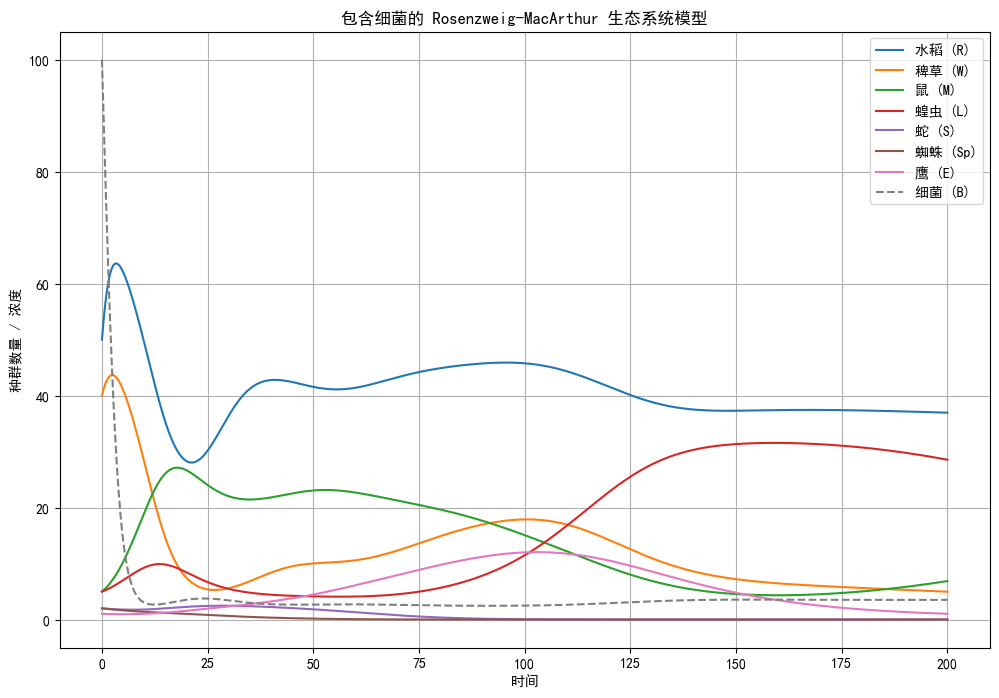

In [15]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def rosenzweig_macarthur_with_bacteria(y, t, params):
    """
    建立一个包含 8 个物种的 Rosenzweig-MacArthur 型模型:
      1)  R(t):  水稻 (生产者)
      2)  W(t):  稗草 (生产者)
      3)  M(t):  鼠 (初级捕食者)         - 吃水稻 R、稗草 W
      4)  L(t):  蝗虫 (初级捕食者)       - 吃水稻 R、稗草 W
      5)  S(t):  蛇 (次级捕食者)         - 吃鼠 M、蝗虫 L
      6)  Sp(t): 蜘蛛 (次级捕食者)       - 吃蝗虫 L
      7)  E(t):  鹰 (顶级捕食者)         - 吃蛇 S、蜘蛛 Sp、鼠 M
      8)  B(t):  细菌 (分解者)           - 利用各物种的死亡，作为自然资源被水稻 R 和稗草 W 消耗

    说明:
    - 细菌 B(t) 的增长来自于所有其他物种的死亡率与种群数量的乘积之和，再乘以系数 alphaB。
    - 水稻 R 和稗草 W 消耗细菌 B 来促进其生长。
    - 鼠 M 和蝗虫 L 不再消费细菌 B。
    - 其余捕食关系保持不变。
    """

    # 解包状态变量
    R, W, M, L, S, Sp, E, B = y

    # 解包参数
    (
        # 生产者参数 (水稻 R, 稗草 W)
        rR, KR,   # 水稻 R 的增长率、环境容量
        rW, KW,   # 稗草 W 的增长率、环境容量

        # 鼠 M 对 (R, W) 的捕食系数与效率
        aRM, bRM, eMR,   # M 吃 R
        aWM, bWM, eMW,   # M 吃 W

        # 蝗虫 L 对 (R, W) 的捕食系数与效率
        aRL, bRL, eLR,   # L 吃 R
        aWL, bWL, eLW,   # L 吃 W

        # 蛇 S 对 (M, L) 的捕食系数与效率
        aSM, bSM, eSM,    # S 吃 M
        aSL, bSL, eSL,    # S 吃 L

        # 蜘蛛 Sp 对 (L) 的捕食系数与效率
        aSpL, bSpL, eSpL,  # Sp 吃 L

        # 鹰 E 对 (S, Sp, M) 的捕食系数与效率
        aES, bES, eES,     # E 吃 S
        aESp, bESp, eESp,  # E 吃 Sp
        aEM, bEM, eEM,     # E 吃 M

        # 水稻 R 和 稗草 W 消耗细菌 B 的参数
        aBR, bBR, eRB,     # R 吃 B
        aBW, bBW, eWB,     # W 吃 B

        # 细菌 B 分解系数
        alphaB,

        # 各物种死亡率 (dR, dW, dM, dL, dS, dSp, dE, dB)
        dR, dW, dM, dL, dS, dSp, dE, dB
    ) = params

    # ------------------------------------------------------
    # 1. 生产者 R(t) 和 W(t) (水稻和稗草)
    #    Logistic 增长 + 消耗细菌 B 促进生长 - 被 M 和 L 消耗 - 自然死亡
    # ------------------------------------------------------
    # 鼠对水稻 R 的消耗
    cons_R_by_M = (aRM * R * M) / (1.0 + bRM * R)
    # 蝗虫对水稻 R 的消耗
    cons_R_by_L = (aRL * R * L) / (1.0 + bRL * R)
    # 水稻 R 消耗细菌 B
    cons_B_by_R = (aBR * B * R) / (1.0 + bBR * B)
    # 水稻 R 从消费 B 中获得的增长
    gain_R_from_B = eRB * cons_B_by_R

    dRdt = rR * R * (1 - R / KR) + gain_R_from_B - cons_R_by_M - cons_R_by_L - dR * R

    # 稗草 W(t) - 类似处理
    cons_W_by_M = (aWM * W * M) / (1.0 + bWM * W)
    cons_W_by_L = (aWL * W * L) / (1.0 + bWL * W)
    cons_B_by_W = (aBW * B * W) / (1.0 + bBW * B)
    gain_W_from_B = eWB * cons_B_by_W

    dWdt = rW * W * (1 - W / KW) + gain_W_from_B - cons_W_by_M - cons_W_by_L - dW * W

    # ------------------------------------------------------
    # 2. 初级捕食者 M(t) 和 L(t) (鼠和蝗虫)
    #    进食生产者 R 和 W -> 增长 - 被更高营养级捕食 - 自然死亡
    # ------------------------------------------------------
    # 鼠 M(t)
    gain_M_from_R = eMR * cons_R_by_M
    gain_M_from_W = eMW * cons_W_by_M

    # 鼠被蛇 S 和鹰 E 捕食
    cons_M_by_S = (aSM * M * S) / (1.0 + bSM * M)
    cons_M_by_E = (aEM * M * E) / (1.0 + bEM * M)

    dMdt = gain_M_from_R + gain_M_from_W - cons_M_by_S - cons_M_by_E - dM * M

    # 蝗虫 L(t)
    gain_L_from_R = eLR * cons_R_by_L
    gain_L_from_W = eLW * cons_W_by_L

    # 蝗虫被蛇 S 和蜘蛛 Sp 捕食
    cons_L_by_S = (aSL * L * S) / (1.0 + bSL * L)
    cons_L_by_Sp = (aSpL * L * Sp) / (1.0 + bSpL * L)

    dLdt = gain_L_from_R + gain_L_from_W - cons_L_by_S - cons_L_by_Sp - dL * L

    # ------------------------------------------------------
    # 3. 次级捕食者 S(t) 和 Sp(t) (蛇和蜘蛛)
    #    进食初级捕食者 -> 增长 - 被鹰捕食 - 自然死亡
    # ------------------------------------------------------
    # 蛇 S(t)
    gain_S_from_M = eSM * cons_M_by_S
    gain_S_from_L = eSL * cons_L_by_S

    # 蛇被鹰 E 捕食
    cons_S_by_E = (aES * S * E) / (1.0 + bES * S)

    dSdt = gain_S_from_M + gain_S_from_L - cons_S_by_E - dS * S

    # 蜘蛛 Sp(t)
    gain_Sp_from_L = eSpL * cons_L_by_Sp

    # 蜘蛛被鹰 E 捕食
    cons_Sp_by_E = (aESp * Sp * E) / (1.0 + bESp * Sp)

    dSpdt = gain_Sp_from_L - cons_Sp_by_E - dSp * Sp

    # ------------------------------------------------------
    # 4. 顶级捕食者 E(t) (鹰)
    #    进食 S, Sp, M -> 增长 - 自然死亡
    # ------------------------------------------------------
    gain_E_from_S = eES * cons_S_by_E
    gain_E_from_Sp = eESp * cons_Sp_by_E
    gain_E_from_M = eEM * cons_M_by_E

    dEdt = gain_E_from_S + gain_E_from_Sp + gain_E_from_M - dE * E

    # ------------------------------------------------------
    # 5. 细菌 B(t) (分解者)
    #    由各物种的死亡贡献增长 - 被 R 和 W 消耗 - 自然死亡
    # ------------------------------------------------------
    # 细菌增长
    total_death_flux = (dR * R + dW * W + dM * M + dL * L + dS * S + dSp * Sp + dE * E)
    bacteria_growth = alphaB * total_death_flux

    # 细菌被生产者消耗
    cons_B_consumed_by_R = cons_B_by_R  # 已在 R 的算式中计算
    cons_B_consumed_by_W = cons_B_by_W  # 已在 W 的算式中计算

    dBdt = bacteria_growth - cons_B_consumed_by_R - cons_B_consumed_by_W - dB * B

    return [dRdt, dWdt, dMdt, dLdt, dSdt, dSpdt, dEdt, dBdt]

# ---------------------------
# 示例参数 (仅用于演示, 请根据实际需要进行调整)
# ---------------------------
params_example = (
    # 水稻 R: logistic
    0.8, 80.0,    # rR, KR
    # 稗草 W: logistic
    0.6, 60.0,    # rW, KW

    # 鼠 M 消费(水稻 R, 稗草 W)
    0.02, 0.01, 0.2,    # aRM, bRM, eMR
    0.02, 0.01, 0.2,    # aWM, bWM, eMW

    # 蝗虫 L 消费(水稻 R, 稗草 W)
    0.015, 0.01, 0.2,   # aRL, bRL, eLR
    0.015, 0.01, 0.2,   # aWL, bWL, eLW

    # 蛇 S 消费(鼠 M, 蝗虫 L)
    0.01, 0.01, 0.3,    # aSM, bSM, eSM
    0.01, 0.01, 0.3,    # aSL, bSL, eSL

    # 蜘蛛 Sp 消费(蝗虫 L)
    0.01, 0.01, 0.35,   # aSpL, bSpL, eSpL

    # 鹰 E 消费(蛇 S, 蜘蛛 Sp, 鼠 M)
    0.01, 0.01, 0.4,    # aES, bES, eES
    0.01, 0.01, 0.4,    # aESp, bESp, eESp
    0.01, 0.01, 0.4,    # aEM, bEM, eEM

    # 水稻 R 消耗细菌 B
    0.005, 0.01, 0.1,   # aBR, bBR, eRB
    # 稗草 W 消耗细菌 B
    0.005, 0.01, 0.1,   # aBW, bBW, eWB

    # 细菌 B 分解系数
    0.2,                 # alphaB

    # 各物种死亡率 (dR, dW, dM, dL, dS, dSp, dE, dB)
    0.02, 0.02, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05
)

# 初始值 [R, W, M, L, S, Sp, E, B]
y0 = [50, 40, 5, 5, 2, 2, 1, 100]

# 时间序列
t = np.linspace(0, 200, 2001)

# 用 odeint 求解
solution = odeint(rosenzweig_macarthur_with_bacteria, y0, t, args=(params_example,))
R_sol, W_sol, M_sol, L_sol, S_sol, Sp_sol, E_sol, B_sol = solution.T

# ---------------------------
# 绘图
#
plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体
plt.figure(figsize=(12, 8))
plt.plot(t, R_sol, label='水稻 (R)')
plt.plot(t, W_sol, label='稗草 (W)')
plt.plot(t, M_sol, label='鼠 (M)')
plt.plot(t, L_sol, label='蝗虫 (L)')
plt.plot(t, S_sol, label='蛇 (S)')
plt.plot(t, Sp_sol, label='蜘蛛 (Sp)')
plt.plot(t, E_sol, label='鹰 (E)')
plt.plot(t, B_sol, label='细菌 (B)', linestyle='--')
plt.xlabel('时间')
plt.ylabel('种群数量 / 浓度')
plt.title('包含细菌的 Rosenzweig-MacArthur 生态系统模型')
plt.legend()
plt.grid(True)
plt.show()

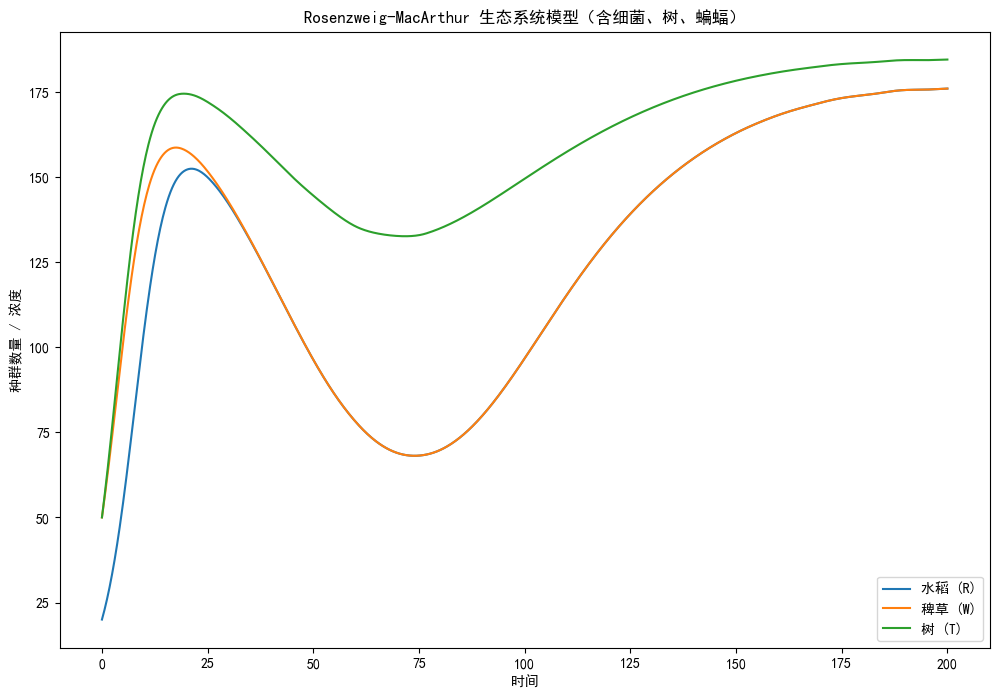

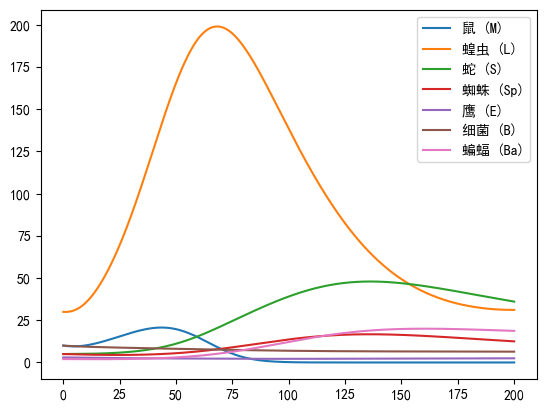

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 在原有的 9 个物种基础上添加第 10 个物种“蝙蝠 (Ba)”，只捕食蝗虫 (L)。

def rosenzweig_macarthur_with_bacteria_tree_bat(t, y, params):
    """
    修改版生态系统动力学模型，包含 10 个物种：
    R (水稻), W (稗草), M (鼠), L (蝗虫), S (蛇),
    Sp (蜘蛛), E (鹰), B (细菌), T (树), Ba (蝙蝠).
    Ba 只捕食 L。
    """
    # 解包状态变量
    R, W, M, L, S, Sp, E, B_, T_, Ba = y

    (
        # ------------------- 原有参数 -------------------
        rR, KR, rW, KW,
        aRM, bRM, eMR, aWM, bWM, eMW,
        aRL, bRL, eLR, aWL, bWL, eLW,
        aSM, bSM, eSM, aSL, bSL, eSL,
        aSpL, bSpL, eSpL,
        aES, bES, eES, aESp, bESp, eESp, aEM, bEM, eEM,
        aBR, bBR, eRB, aBW, bBW, eWB,
        alphaB, dR, dW, dM, dL, dS, dSp, dE, dB,
        rT, KT, aTM, bTM, eTM, aTL, bTL, eTL, dT,
        # ------------------- 新增蝙蝠相关参数 -------------------
        aBaL, bBaL, eBaL, dBa
    ) = params

    #------------------- 与原有物种相关的计算 -------------------
    # 1) 水稻 R
    cons_R_by_M = (aRM * R * M) / (1.0 + bRM * R)
    cons_R_by_L = (aRL * R * L) / (1.0 + bRL * R)
    cons_B_by_R = (aBR * B_ * R) / (1.0 + bBR * B_)
    gain_R_from_B = eRB * cons_B_by_R
    dRdt = rR * R * (1 - R / KR) + gain_R_from_B - cons_R_by_M - cons_R_by_L - dR * R

    # 2) 稗草 W
    cons_W_by_M = (aWM * W * M) / (1.0 + bWM * W)
    cons_W_by_L = (aWL * W * L) / (1.0 + bWL * W)
    cons_B_by_W = (aBW * B_ * W) / (1.0 + bBW * B_)
    gain_W_from_B = eWB * cons_B_by_W
    dWdt = rW * W * (1 - W / KW) + gain_W_from_B - cons_W_by_M - cons_W_by_L - dW * W

    # 3) 树 T
    cons_T_by_M = (aTM * T_ * M) / (1.0 + bTM * T_)
    cons_T_by_L = (aTL * T_ * L) / (1.0 + bTL * T_)
    gain_M_from_T = eTM * cons_T_by_M
    gain_L_from_T = eTL * cons_T_by_L
    dTdt = rT * T_ * (1 - T_ / KT) - cons_T_by_M - cons_T_by_L - dT * T_

    # 4) 鼠 M
    gain_M_from_R = eMR * cons_R_by_M
    gain_M_from_W = eMW * cons_W_by_M
    cons_M_by_S = (aSM * M * S) / (1.0 + bSM * M)
    cons_M_by_E = (aEM * M * E) / (1.0 + bEM * M)
    dMdt = gain_M_from_R + gain_M_from_W + gain_M_from_T - cons_M_by_S - cons_M_by_E - dM * M

    # 5) 蝗虫 L
    gain_L_from_R = eLR * cons_R_by_L
    gain_L_from_W = eLW * cons_W_by_L
    cons_L_by_S = (aSL * L * S) / (1.0 + bSL * L)
    cons_L_by_Sp = (aSpL * L * Sp) / (1.0 + bSpL * L)
    # 蝙蝠捕食蝗虫
    cons_L_by_Ba = (aBaL * L * Ba) / (1.0 + bBaL * L)
    dLdt = (gain_L_from_R + gain_L_from_W + gain_L_from_T
            - cons_L_by_S - cons_L_by_Sp
            - cons_L_by_Ba
            - dL * L)

    # 6) 蛇 S
    gain_S_from_M = eSM * cons_M_by_S
    gain_S_from_L = eSL * cons_L_by_S
    cons_S_by_E = (aES * S * E) / (1.0 + bES * S)
    dSdt = gain_S_from_M + gain_S_from_L - cons_S_by_E - dS * S

    # 7) 蜘蛛 Sp
    gain_Sp_from_L = eSpL * cons_L_by_Sp
    cons_Sp_by_E = (aESp * Sp * E) / (1.0 + bESp * Sp)
    dSpdt = gain_Sp_from_L - cons_Sp_by_E - dSp * Sp

    # 8) 鹰 E
    gain_E_from_S = eES * cons_S_by_E
    gain_E_from_Sp = eESp * cons_Sp_by_E
    gain_E_from_M = eEM * cons_M_by_E
    dEdt = gain_E_from_S + gain_E_from_Sp + gain_E_from_M - dE * E

    # 9) 细菌 B
    total_death_flux = (
        dR * R + dW * W + dM * M +
        dL * L + dS * S + dSp * Sp +
        dE * E + dT * T_
    )
    bacteria_growth = alphaB * total_death_flux
    dBdt = bacteria_growth - dB * B_

    # 10) 蝙蝠 Ba
    # 仅捕食蝗虫，获得能量
    gain_Ba_from_L = eBaL * cons_L_by_Ba
    # 自然死亡率 dBa
    dBadt = gain_Ba_from_L - dBa * Ba

    return [dRdt, dWdt, dMdt, dLdt, dSdt, dSpdt, dEdt, dBdt, dTdt, dBadt]


def generate_value_bat(pars, init_val, t_end, num_points):
    t_span = (0, t_end)
    t_eval = np.linspace(0, t_end, num_points)
    sol = solve_ivp(rosenzweig_macarthur_with_bacteria_tree_bat,
                    t_span, init_val, args=(pars,),
                    t_eval=t_eval, method='RK45')
    return sol


def my_plot_bat(sol):
    """ 在图表中包含新加入的蝙蝠 (Ba) 种群 """
    plt.rcParams['font.family'] = 'SimHei'
    plt.figure(figsize=(12, 8))
    plt.xlabel('时间')
    plt.ylabel('种群数量 / 浓度')
    plt.title('Rosenzweig-MacArthur 生态系统模型（含细菌、树、蝙蝠）')

    labels = [
        '水稻 (R)', '稗草 (W)', '鼠 (M)', '蝗虫 (L)', '蛇 (S)',
        '蜘蛛 (Sp)', '鹰 (E)', '细菌 (B)', '树 (T)', '蝙蝠 (Ba)'
    ]
    for i, label in enumerate(labels):
        if i==0 or i==1 or i==8:
            plt.plot(sol.t, sol.y[i], label=label)

    plt.legend()
    plt.show()
    for i, label in enumerate(labels):
        if i!=0 and i!=1 and i!=8:
            plt.plot(sol.t, sol.y[i], label=label)
    plt.legend()
    plt.show()


# 示例参数配置说明：
# - 前 52 个参数与之前模型一致，最后 4 个是蝙蝠相关参数：
#   aBaL, bBaL, eBaL, dBa
example_params_with_bat = (
    0.3, 200,        # rR, KR
    0.3, 200,        # rW, KW
    0.001, 0.001, 0.2,  # aRM, bRM, eMR
    0.001, 0.001, 0.2,  # aWM, bWM, eMW
    0.001, 0.001, 0.2,  # aRL, bRL, eLR
    0.001, 0.001, 0.2,  # aWL, bWL, eLW
    0.005, 0.005, 0.2,  # aSM, bSM, eSM
    0.001, 0.001, 0.2,  # aSL, bSL, eSL
    0.001, 0.001, 0.2,  # aSpL, bSpL, eSpL
    0.001, 0.001, 0.2,  # aES, bES, eES
    0.001, 0.001, 0.2,  # aESp, bESp, eESp
    0.001, 0.001, 0.2,  # aEM, bEM, eEM
    0.001, 0.001, 0.1,  # aBR, bBR, eRB
    0.001, 0.001, 0.1,  # aBW, bBW, eWB
    0.01,               # alphaB
    0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,  # dR, dW, dM, dL, dS, dSp, dE, dB
    0.3, 200,          # rT, KT
    0.0005, 0.001, 0.2,  # aTM, bTM, eTM
    0.0005, 0.001, 0.2,  # aTL, bTL, eTL
    0.01,               # dT
    # ---------- 蝙蝠新参数 ----------
    0.001, 0.001, 0.25, 0.01  # aBaL, bBaL, eBaL, dBa
)

# 初始值增加蝙蝠（Ba），其余与之前类似
# R, W, M, L, S, Sp, E, B, T, Ba
init_val_bat = [20, 50, 10, 30, 5, 5, 3, 10, 50, 2]

# 运行示例
if __name__ == "__main__":
    sol_bat = generate_value_bat(example_params_with_bat, init_val_bat, 200, 1001)
    my_plot_bat(sol_bat)

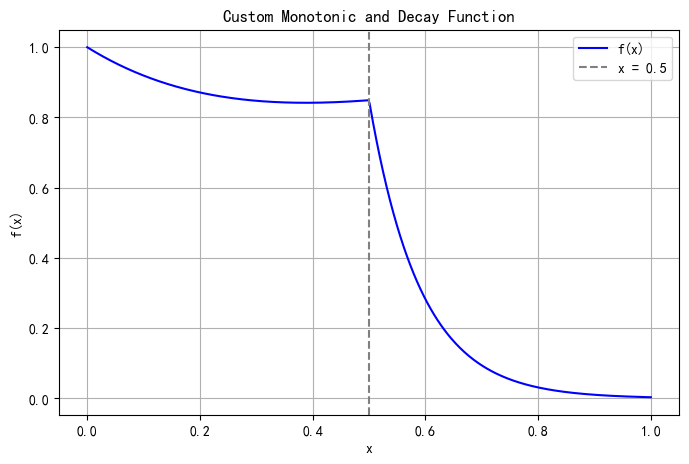

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 定义分段函数
def custom_function(x,t):
    if x <= 0.5:
        return (1 + 1.6* x**2)*np.exp(-t/200)  # 递增部分
    else:
        return 1.4 * np.exp(-10 * (x - 0.5))*np.exp(-t/200)  # 快速下降部分

# 生成数据点
x_values = np.linspace(0, 1, 500)
y_values = np.array([custom_function(x, 200*x) for x in x_values])

# 绘制函数曲线
plt.figure(figsize=(8, 5))
plt.plot(x_values, y_values, label="f(x)", color='b')
plt.axvline(0.5, linestyle="--", color="gray", label="x = 0.5")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Custom Monotonic and Decay Function")
plt.legend()
plt.grid()

# 显示图像
plt.show()


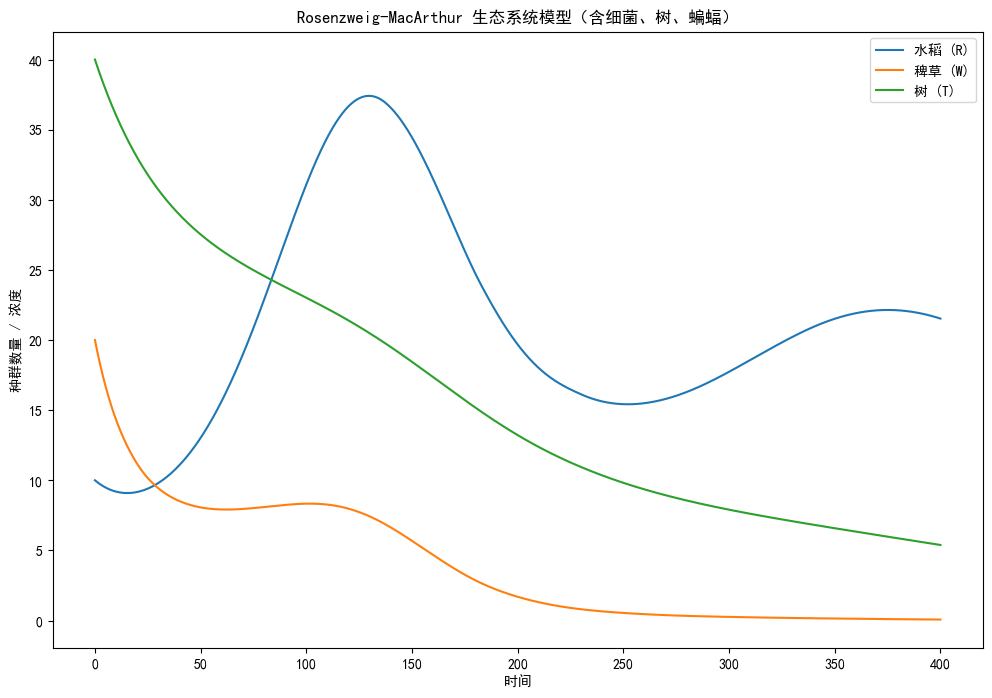

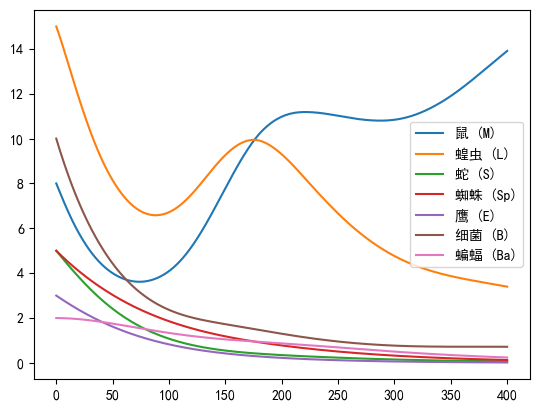

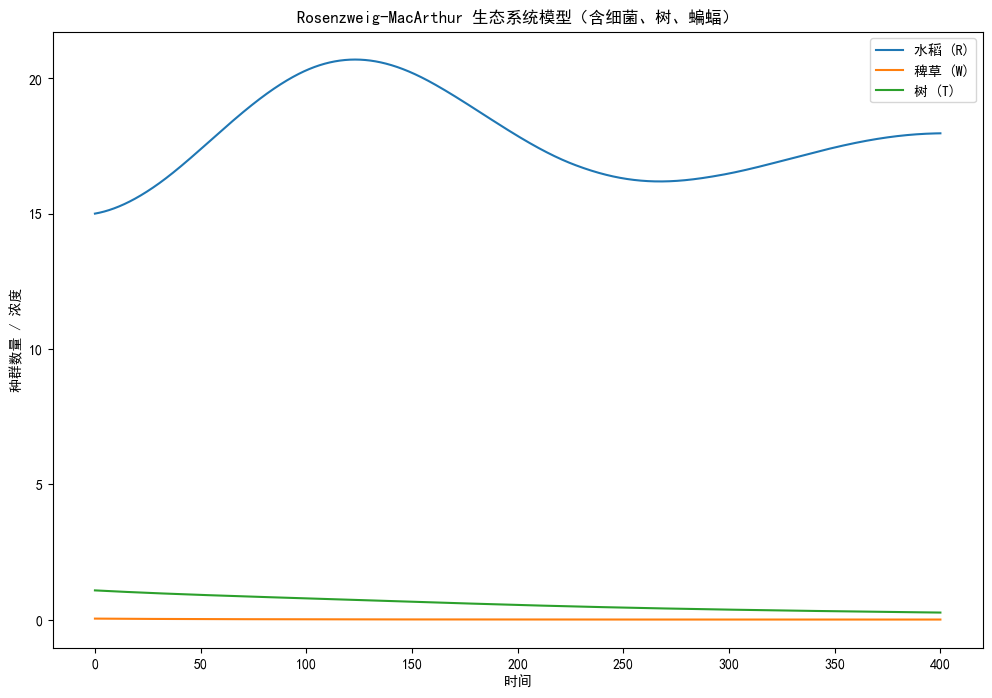

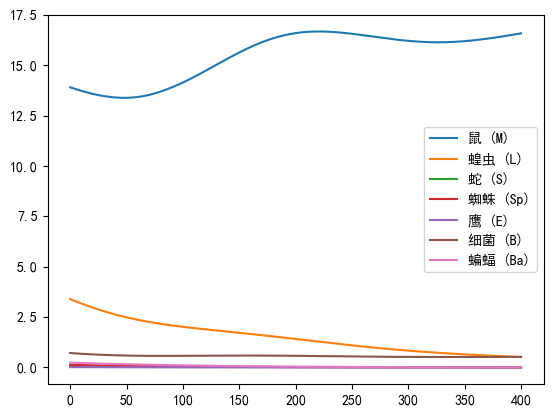

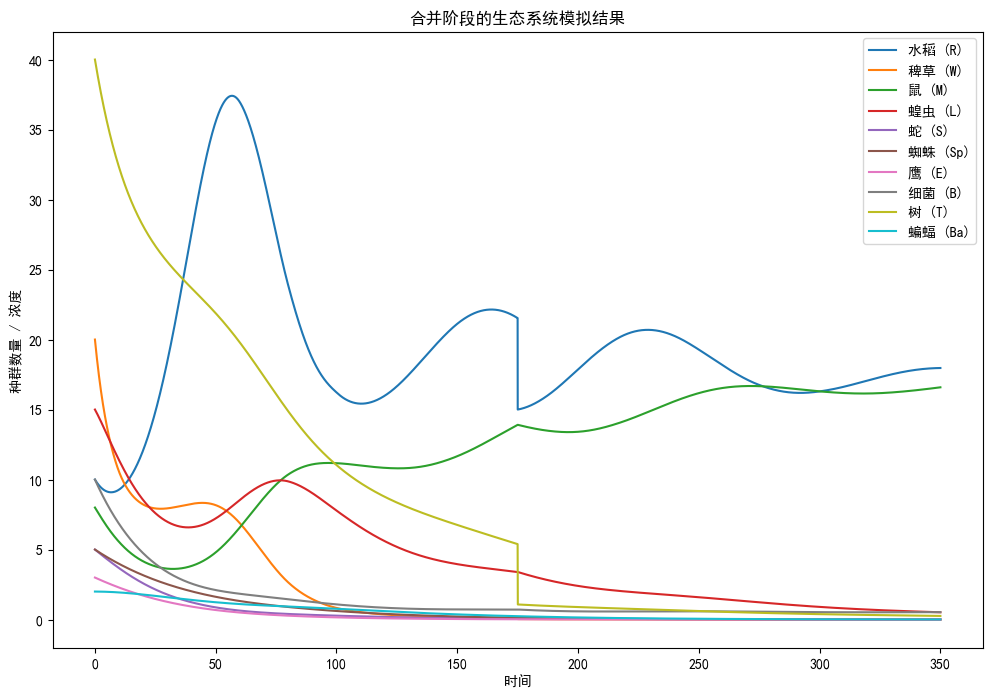

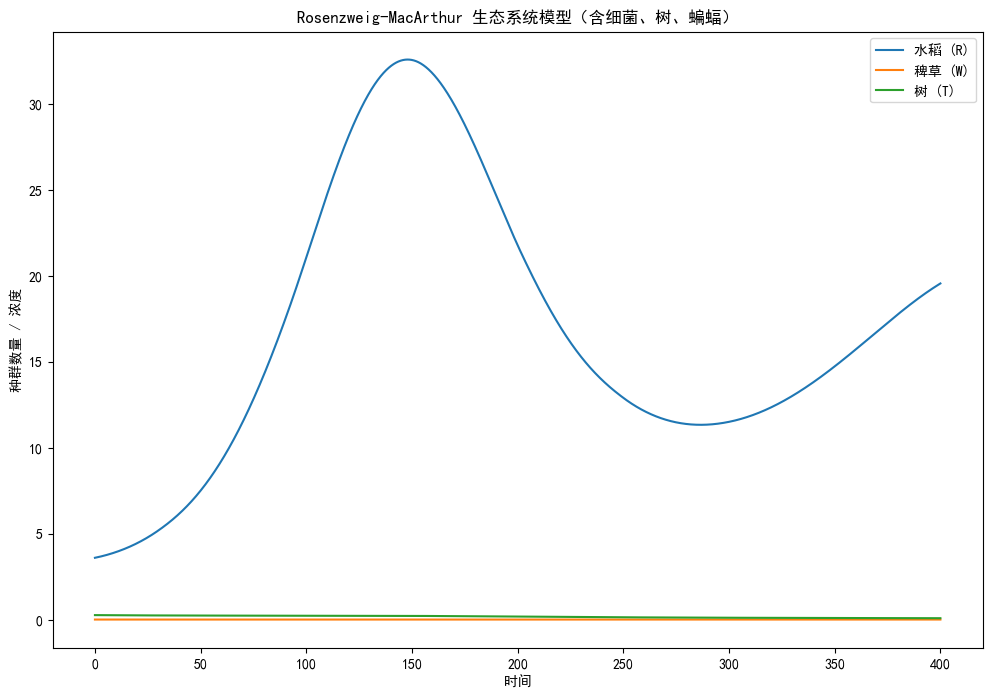

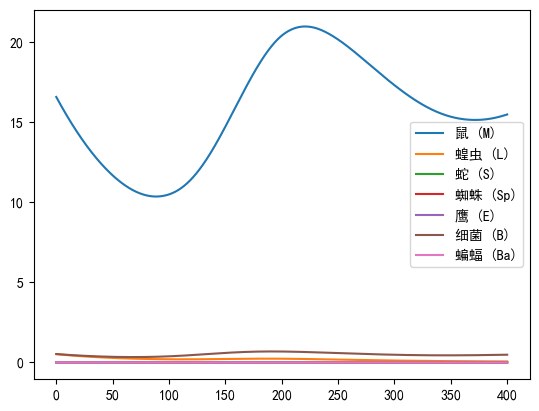

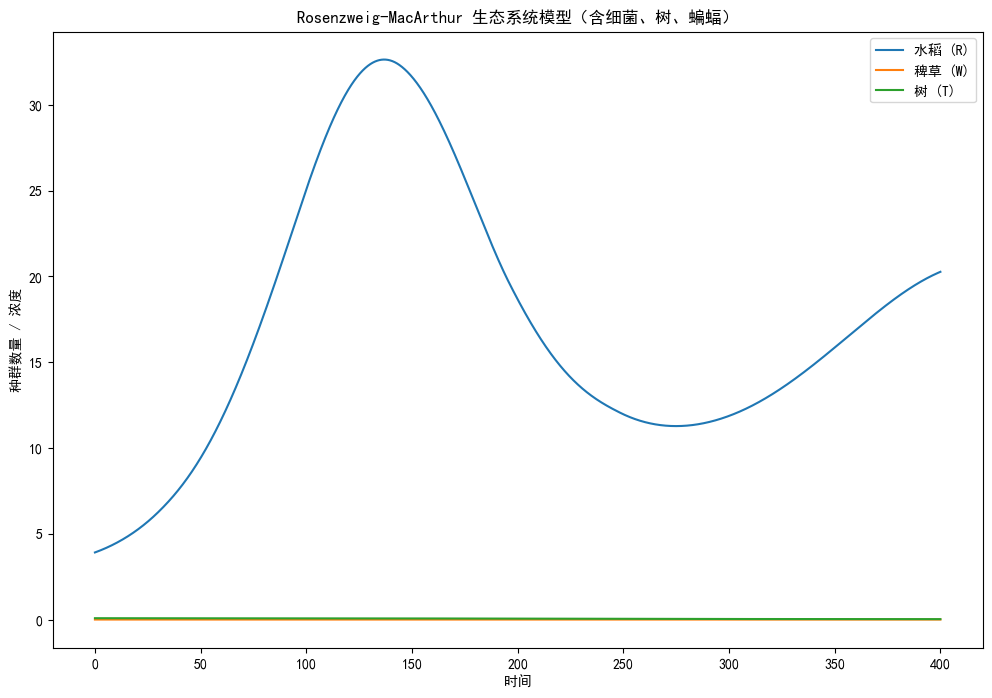

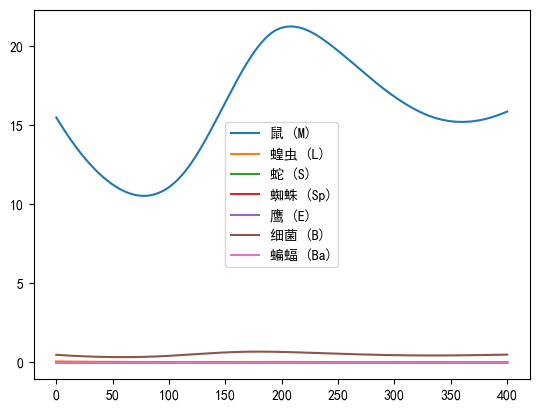

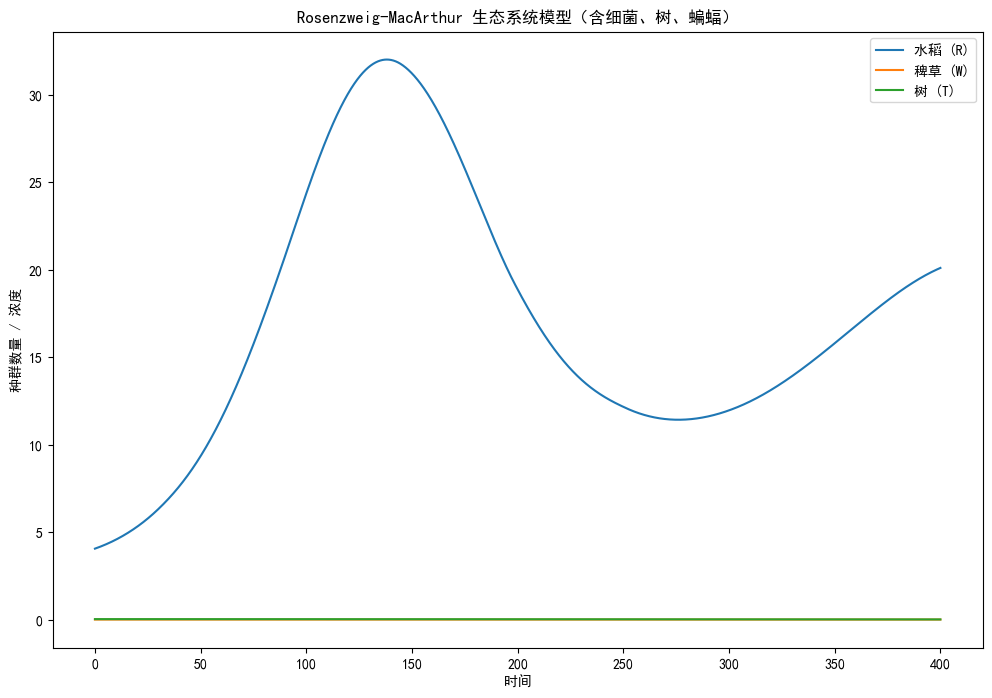

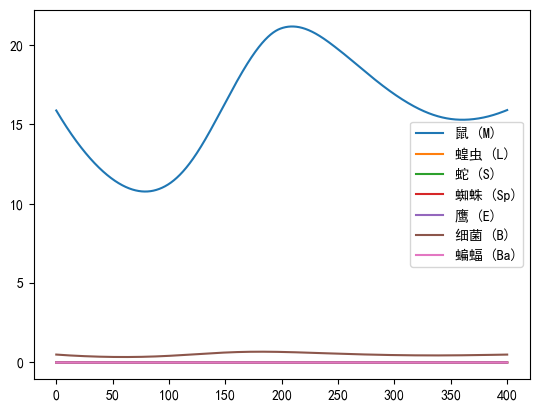

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def rosenzweig_macarthur_with_bacteria_tree_bat(t, y, params):
    """
    Modified ecosystem model with 10 species:
    R (rice), W (weeds), M (mice), L (locusts), S (snakes),
    Sp (spiders), E (eagles), B (bacteria), T (trees), Ba (bats).
    """
    R, W, M, L, S, Sp, E, B_, T_, Ba = y
    (
        # ---------- Original 9-species parameters ----------
        rR, KR, rW, KW,
        aRM, bRM, eMR, aWM, bWM, eMW,
        aRL, bRL, eLR, aWL, bWL, eLW,
        aSM, bSM, eSM, aSL, bSL, eSL,
        aSpL, bSpL, eSpL,
        aES, bES, eES, aESp, bESp, eESp, aEM, bEM, eEM,
        aBR, bBR, eRB, aBW, bBW, eWB,
        alphaB, dR, dW, dM, dL, dS, dSp, dE, dB,
        rT, KT, aTM, bTM, eTM, aTL, bTL, eTL, dT,
        # ---------- Bat-specific parameters ----------
        aBaL, bBaL, eBaL, dBa,
        # ---------- Example: fertilizer or other  ----------
        fert_param
    ) = params

    # 1) Rice (R)
    cons_R_by_M = (aRM * R * M) / (1.0 + bRM * R)
    cons_R_by_L = (aRL * R * L) / (1.0 + bRL * R)
    cons_B_by_R = (aBR * B_ * R) / (1.0 + bBR * B_)
    gain_R_from_B = eRB * cons_B_by_R
    dRdt = rR * R * (1 - R / KR) + gain_R_from_B - cons_R_by_M - cons_R_by_L - dR * R

    # 2) Weeds (W)
    cons_W_by_M = (aWM * W * M) / (1.0 + bWM * W)
    cons_W_by_L = (aWL * W * L) / (1.0 + bWL * W)
    cons_B_by_W = (aBW * B_ * W) / (1.0 + bBW * B_)
    gain_W_from_B = eWB * cons_B_by_W
    dWdt = rW * W * (1 - W / KW) + gain_W_from_B - cons_W_by_M - cons_W_by_L - dW * W

    # 3) Tree (T)
    cons_T_by_M = (aTM * T_ * M) / (1.0 + bTM * T_)
    cons_T_by_L = (aTL * T_ * L) / (1.0 + bTL * T_)
    gain_M_from_T = eTM * cons_T_by_M
    gain_L_from_T = eTL * cons_T_by_L
    dTdt = rT * T_ * (1 - T_ / KT) - cons_T_by_M - cons_T_by_L - dT * T_

    # 4) Mice (M)
    gain_M_from_R = eMR * cons_R_by_M
    gain_M_from_W = eMW * cons_W_by_M
    cons_M_by_S = (aSM * M * S) / (1.0 + bSM * M)
    cons_M_by_E = (aEM * M * E) / (1.0 + bEM * M)
    dMdt = gain_M_from_R + gain_M_from_W + gain_M_from_T - cons_M_by_S - cons_M_by_E - dM * M

    # 5) Locusts (L)
    gain_L_from_R = eLR * cons_R_by_L
    gain_L_from_W = eLW * cons_W_by_L
    cons_L_by_S = (aSL * L * S) / (1.0 + bSL * L)
    cons_L_by_Sp = (aSpL * L * Sp) / (1.0 + bSpL * L)
    cons_L_by_Ba = (aBaL * L * Ba) / (1.0 + bBaL * L)
    dLdt = (gain_L_from_R + gain_L_from_W + gain_L_from_T
            - cons_L_by_S - cons_L_by_Sp - cons_L_by_Ba - dL * L)

    # 6) Snake (S)
    gain_S_from_M = eSM * cons_M_by_S
    gain_S_from_L = eSL * cons_L_by_S
    cons_S_by_E = (aES * S * E) / (1.0 + bES * S)
    dSdt = gain_S_from_M + gain_S_from_L - cons_S_by_E - dS * S

    # 7) Spider (Sp)
    gain_Sp_from_L = eSpL * cons_L_by_Sp
    cons_Sp_by_E = (aESp * Sp * E) / (1.0 + bESp * Sp)
    dSpdt = gain_Sp_from_L - cons_Sp_by_E - dSp * Sp

    # 8) Eagle (E)
    gain_E_from_S = eES * cons_S_by_E
    gain_E_from_Sp = eESp * cons_Sp_by_E
    gain_E_from_M = eEM * cons_M_by_E
    dEdt = gain_E_from_S + gain_E_from_Sp + gain_E_from_M - dE * E

    # 9) Bacteria (B)
    total_death_flux = (
        dR * R + dW * W + dM * M + dL * L + dS * S + dSp * Sp + dE * E + dT * T_
    )
    bacteria_growth = alphaB * total_death_flux
    dBdt = bacteria_growth - dB * B_

    # 10) Bat (Ba)
    gain_Ba_from_L = eBaL * cons_L_by_Ba
    dBadt = gain_Ba_from_L - dBa * Ba

    return [dRdt, dWdt, dMdt, dLdt, dSdt, dSpdt, dEdt, dBdt, dTdt, dBadt]


def generate_value_bat(pars, init_val, t_end, dt):
    """Helper function to solve the ODE system."""
    t_span = (0, t_end)
    num_points = int(t_end / dt) + 1
    t_eval = np.linspace(0, t_end, num_points)

    sol = solve_ivp(
        rosenzweig_macarthur_with_bacteria_tree_bat,
        t_span,
        init_val,
        args=(pars,),
        t_eval=t_eval,
        method='RK45'
    )
    return sol


def my_plot_bat(sol):
    """Plot 10-species results, including the new bat species."""
    plt.rcParams['font.family'] = 'SimHei'
    plt.figure(figsize=(12, 8))
    plt.xlabel('时间')
    plt.ylabel('种群数量 / 浓度')
    plt.title('Rosenzweig-MacArthur 生态系统模型（含细菌、树、蝙蝠）')

    labels = [
        '水稻 (R)', '稗草 (W)', '鼠 (M)', '蝗虫 (L)', '蛇 (S)',
        '蜘蛛 (Sp)', '鹰 (E)', '细菌 (B)', '树 (T)', '蝙蝠 (Ba)'
    ]
    for i, label in enumerate(labels):
        if i==0 or i==1 or i==8:
            plt.plot(sol.t, sol.y[i], label=label)

    plt.legend()
    plt.show()
    for i, label in enumerate(labels):
        if i!=0 and i!=1 and i!=8:
            plt.plot(sol.t, sol.y[i], label=label)
    plt.legend()
    plt.show()


def my_plot_yt(y_mat, t_vec):
    """Plot a combined solution from multiple simulation stages."""
    plt.figure(figsize=(12, 8))
    plt.xlabel('时间')
    plt.ylabel('种群数量 / 浓度')
    plt.title('合并阶段的生态系统模拟结果')

    labels = [
        '水稻 (R)', '稗草 (W)', '鼠 (M)', '蝗虫 (L)',
        '蛇 (S)', '蜘蛛 (Sp)', '鹰 (E)', '细菌 (B)',
        '树 (T)', '蝙蝠 (Ba)'
    ]
    for i, label in enumerate(labels):
        plt.plot(t_vec, y_mat[i], label=label)
    plt.legend()
    plt.show()


def from_forest():
    """
    Example simulation with adjusted parameters to restrict excessive producer growth
    and allow more noticeable consumer populations.
    """
    # Adjusted parameters (note lower growth rates and/or higher death rates for R, W, T)
    par = (
        0.08, 150,       # rR, KR (rice)
        0.05, 150,       # rW, KW (weeds)
        0.003, 0.001, 0.2,   # aRM, bRM, eMR
        0.003, 0.001, 0.2,   # aWM, bWM, eMW
        0.003, 0.001, 0.2,   # aRL, bRL, eLR
        0.003, 0.001, 0.2,   # aWL, bWL, eLW
        0.005, 0.005, 0.2,   # aSM, bSM, eSM
        0.001, 0.001, 0.2,   # aSL, bSL, eSL
        0.001, 0.001, 0.2,   # aSpL, bSpL, eSpL
        0.001, 0.001, 0.2,   # aES, bES, eES
        0.001, 0.001, 0.2,   # aESp, bESp, eESp
        0.001, 0.001, 0.2,   # aEM, bEM, eEM
        0.001, 0.001, 0.1,   # aBR, bBR, eRB
        0.001, 0.001, 0.1,   # aBW, bBW, eWB
        0.02,                # alphaB (slightly higher decomposition -> helps control producers)
        0.02, 0.015, 0.01, 0.015, 0.02, 0.01, 0.015, 0.02,  # dR, dW, dM, dL, dS, dSp, dE, dB
        0.02, 150,           # rT, KT (trees)
        0.0005, 0.001, 0.2,  # aTM, bTM, eTM
        0.0005, 0.001, 0.2,  # aTL, bTL, eTL
        0.015,               # dT (increased tree death to control overgrowth)
        0.003, 0.001, 0.22, 0.01,  # aBaL, bBaL, eBaL, dBa (bats)
        0.0                  # fertilizer or additional param
    )

    # Lower initial population for R and W but keep locusts, mice, etc.
    init_val0 = [10, 20, 8, 15, 5, 5, 3, 10, 40, 2]
    sol_0 = generate_value_bat(par, init_val0, 400, 0.1)
    my_plot_bat(sol_0)

    # Next stage: "Clearing" or environment change
    stage2_init0 = sol_0.y[:, -1].copy()
    # Decrease available trees and weeds to simulate clearing effect
    stage2_init0[8] *= 0.2  # T
    stage2_init0[1] *= 0.5  # W
    stage2_init0[0] = 15    # R re-planted or changed
    par_stage2 = list(par)
    # Increase fertilizer effect or some param if you want
    par_stage2[-1] = 0.05
    sol_stage2 = generate_value_bat(par_stage2, stage2_init0, 400, 0.1)
    my_plot_bat(sol_stage2)

    # Combine the results
    y12 = np.hstack((sol_0.y, sol_stage2.y))
    t12 = np.linspace(0, 350, y12.shape[1])  # adjust total time
    my_plot_yt(y12, t12)

    # Additional repeated clearance or harvest steps
    sim_num = 3
    stage_3_init = sol_stage2.y[:, -1].copy()
    for idx in range(sim_num):
        stage_3_init[0] *= 0.2  # reduce R drastically on each harvest
        sol_stage3 = generate_value_bat(par_stage2, stage_3_init, 400, 0.1)
        my_plot_bat(sol_stage3)
        # Prepare for next iteration
        stage_3_init = sol_stage3.y[:, -1].copy()


if __name__ == "__main__":
    from_forest()